### Installing and Importing the Packages and Libraries

In [ ]:
# Install necessary libraries
!pip install diffusers transformers accelerate datasets safetensors xformers
!pip install datasets
!pip install torch torchvision transformers diffusers datasets accelerate
!pip install invisible_watermark transformers accelerate safetensors

# Import required libraries
import os
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from diffusers import StableDiffusionPipeline, DDPMScheduler, UNet2DConditionModel
from transformers import AutoTokenizer
import torch
from torch.optim import AdamW
from tqdm import tqdm
from datasets import load_dataset
import requests
from io import BytesIO

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset = load_dataset("RIW/small-coco", split="train")



### Using the MSCoco Dataset

In [ ]:
# Prepare directories for saving images and captions
os.makedirs("./coco_images", exist_ok=True)
os.makedirs("./coco_captions", exist_ok=True)

# Save images and captions
for i, data in enumerate(dataset):
    # Extract URL and caption
    url = data["url"]
    caption = data["caption"]

    # Download and save the image
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert("RGB")
    image.save(f"./coco_images/image_{i}.jpg")

    # Save the caption
    with open(f"./coco_captions/caption_{i}.txt", "w") as f:
        f.write(caption)

    # To limit the number of images processed, you can add a condition to stop after a certain number
    if i >= 5000:  # For example, only process the first 5000 images
        break

print("Images and captions saved!")

Images and captions saved!


In [ ]:
from diffusers import DiffusionPipeline
import torch

In [ ]:
from diffusers import DiffusionPipeline
import torch

pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
device = "cuda"
pipe.to(device)

# if using torch < 2.0
# pipe.enable_xformers_memory_efficient_attention()

prompt = "A young man with an umbrella standing with cattle"

images = pipe(prompt=prompt).images[0]


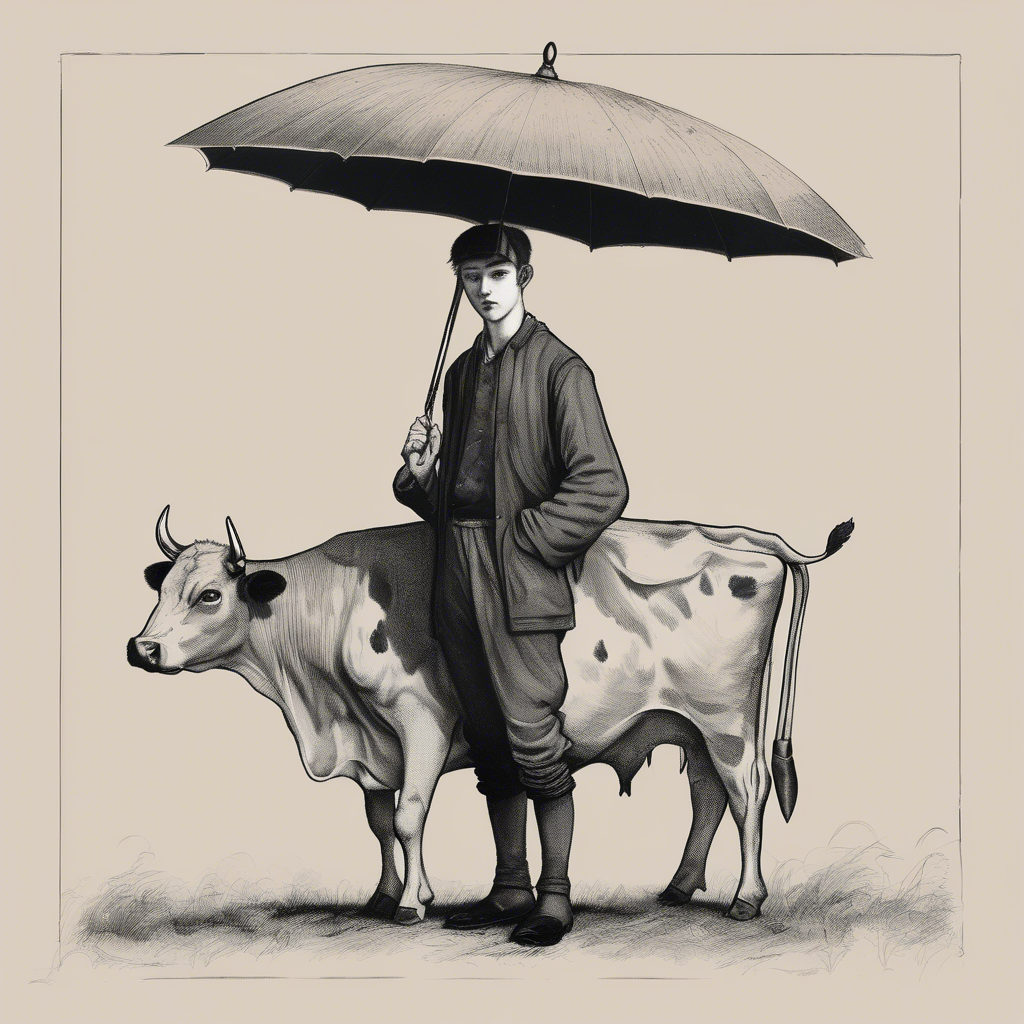

In [ ]:
from IPython.display import display
display(images)


In [ ]:
print(pipe)

StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}



In [ ]:
import os
import json

# Paths to your folders
images_folder = 'coco_images/'
captions_folder = 'coco_captions/'
# Get the list of image files (assuming .jpg or .png)
image_files = [f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.png'))]
# Get the list of image files and caption files
image_files = sorted([f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.png'))])
caption_files = sorted([f for f in os.listdir(captions_folder) if f.startswith('caption_') and f.endswith('.txt')])

# Ensure that the number of images and captions are the same
if len(image_files) != len(caption_files):
    raise ValueError(f"The number of images ({len(image_files)}) does not match the number of captions ({len(caption_files)}). Please check your dataset.")

# Prepare the dataset list
dataset = []

# Pair images with captions based on the numbers in the filenames
for i in range(len(image_files)):
    # Extract the number from the filename (e.g., image_1.jpg -> 1)
    image_number = image_files[i].split('_')[1].split('.')[0]  # Extracting the number part

    # Find the corresponding caption file based on the extracted number
    caption_filename = f"caption_{image_number}.txt"

    if caption_filename in caption_files:
        image_file = image_files[i]
        caption_file = caption_filename

        # Construct the paths
        image_path = os.path.join(images_folder, image_file)
        caption_path = os.path.join(captions_folder, caption_file)

        # Read the caption
        with open(caption_path, 'r') as file:
            caption = file.read().strip()

        # Create an entry for the dataset
        dataset.append({
            "image": image_path,
            "caption": caption
        })
    else:
        print(f"Warning: No matching caption for image {image_number}")

# Save the dataset to a JSON file
dataset_path = 'coco_dataset.json'
with open(dataset_path, 'w') as f:
    json.dump(dataset, f, indent=4)

print(f"Dataset saved to {dataset_path}")

Dataset saved to coco_dataset.json


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import StableDiffusionXLPipeline
from PIL import Image
import os
from torchvision import transforms
from tqdm import tqdm

device = "cuda"


In [ ]:
class CocoDataset(Dataset):
    def __init__(self, coco_data, tokenizer, transform=None):
        self.data = coco_data  # List of image-caption pairs
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = item['image']
        caption = item['caption']

        # Load the image
        image = Image.open(image_path).convert("RGB")

        # Preprocess the image
        if self.transform:
            image = self.transform(image)

        # Tokenize the caption
        inputs = self.tokenizer(caption, padding="max_length", truncation=True, max_length=77, return_tensors="pt")

        return {
            'pixel_values': image,
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0)
        }


In [ ]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize images to the required size
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize the images
])


In [ ]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
text_encoder.to(device)


In [ ]:
# Load the dataset from the saved JSON file
import json
with open('coco_dataset.json', 'r') as f:
    coco_data = json.load(f)

# Create dataset and dataloaders
dataset = CocoDataset(coco_data, tokenizer, transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)


In [ ]:
import torch

torch.cuda.empty_cache()  # Clear unused memory

### Start Finetuning

In [ ]:
import torch
from torch.optim import AdamW
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the pipeline to the device
pipe.to(device)

# Define the optimizer for individual components
optimizer = AdamW(
    list(pipe.unet.parameters()) +
    list(pipe.vae.parameters()) +
    list(pipe.text_encoder.parameters()),
    lr=5e-6
)

# Training setup
epochs = 5  # Number of epochs
gradient_accumulation_steps = 4  # For accumulating gradients
scaler = GradScaler()

# Training loop
for epoch in range(epochs):
    pipe.unet.train()  # Set UNet to training mode

    for batch in tqdm(dataloader):
        optimizer.zero_grad()

        # Validate batch inputs
        pixel_values = batch.get('pixel_values', None)
        input_ids = batch.get('input_ids', None)
        attention_mask = batch.get('attention_mask', None)

        if pixel_values is None or input_ids is None or attention_mask is None:
            raise ValueError("Input batch is missing required keys (pixel_values, input_ids, attention_mask).")

        # Move inputs to the device
        pixel_values = pixel_values.to(device).half()
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        torch.cuda.empty_cache()  # Clear unused memory
        # Initialize loss
        loss = None

        try:
            # Encode the pixel values using the VAE
            with autocast():
                latents = pipe.vae.encode(pixel_values).latent_dist.sample()
                latents = latents.to(device)

                # Generate text embeddings using the text encoder
                text_embeddings = pipe.text_encoder(input_ids)[0]

                # Sample a random timestep
                timestep = torch.randint(0, 1000, (latents.shape[0],), device=device)

                # Forward pass through the UNet
                outputs = pipe.unet(
                    latents,
                    timestep=timestep,
                    encoder_hidden_states=text_embeddings,
                    attention_mask=attention_mask
                )

                # Check for loss in outputs
                if hasattr(outputs, 'loss') and outputs.loss is not None:
                    loss = outputs.loss
                else:
                    # Define your own loss function here if needed
                    raise ValueError("The UNet output does not include 'loss'. Verify the model output.")

            # Perform backward pass with gradient scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        except Exception as e:
            print(f"Error during forward/backward pass: {e}")
            continue

        # Print loss for this batch if no exception occurred
        if loss is not None:
            print(f"Batch Loss: {loss.item()}")
    del pixel_values, input_ids, attention_mask
    torch.cuda.empty_cache()
    # Print epoch loss summary (if at least one batch succeeded)
    if loss is not None:
        print(f"Epoch [{epoch + 1}/{epochs}], Last Batch Loss: {loss.item()}")

# Save the fine-tuned model
pipe.save_pretrained("fine_tuned_stable_diffusion")


<ipython-input-17-78ce8d6c854d>:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
  0%|          | 0/640 [00:00<?, ?it/s]<ipython-input-17-78ce8d6c854d>:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 1/640 [00:00<02:37,  4.05it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  0%|          | 3/640 [00:00<01:39,  6.42it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  1%|          | 5/640 [00:00<01:56,  5.46it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 362.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  1%|          | 7/640 [00:01<01:46,  5.94it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  1%|▏         | 9/640 [00:01<01:39,  6.33it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  2%|▏         | 11/640 [00:01<01:55,  5.46it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 362.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  2%|▏         | 13/640 [00:02<01:44,  6.02it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  2%|▏         | 14/640 [00:02<01:37,  6.41it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  2%|▎         | 16/640 [00:02<01:44,  5.95it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 368.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  3%|▎         | 18/640 [00:02<01:30,  6.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 366.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  3%|▎         | 20/640 [00:03<01:40,  6.18it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  3%|▎         | 22/640 [00:03<01:42,  6.03it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  4%|▎         | 23/640 [00:03<01:41,  6.08it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  4%|▍         | 24/640 [00:04<01:55,  5.31it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 361.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  4%|▍         | 27/640 [00:04<01:32,  6.63it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 17.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 356.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  5%|▍         | 29/640 [00:04<01:40,  6.07it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  5%|▍         | 31/640 [00:05<01:35,  6.37it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  5%|▌         | 33/640 [00:05<01:37,  6.26it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 366.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  5%|▌         | 35/640 [00:05<01:38,  6.16it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  6%|▌         | 37/640 [00:06<01:39,  6.05it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 370.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  6%|▌         | 39/640 [00:06<01:41,  5.95it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  6%|▋         | 41/640 [00:06<01:35,  6.26it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  7%|▋         | 43/640 [00:07<01:38,  6.07it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 365.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  7%|▋         | 45/640 [00:07<01:39,  6.01it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  7%|▋         | 47/640 [00:07<01:33,  6.31it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 365.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  8%|▊         | 49/640 [00:08<01:38,  6.01it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  8%|▊         | 51/640 [00:08<01:34,  6.21it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  8%|▊         | 53/640 [00:08<01:37,  6.02it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 15.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.23 GiB is allocated by PyTorch, and 381.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  9%|▊         | 55/640 [00:09<01:32,  6.29it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  9%|▉         | 57/640 [00:09<01:33,  6.22it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 15.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 373.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  9%|▉         | 59/640 [00:09<01:33,  6.21it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 10%|▉         | 61/640 [00:09<01:31,  6.36it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 10%|▉         | 62/640 [00:10<01:47,  5.39it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 15.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 373.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 10%|█         | 65/640 [00:10<01:27,  6.55it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 364.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 10%|█         | 67/640 [00:10<01:32,  6.18it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 11%|█         | 69/640 [00:11<01:29,  6.38it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 11%|█         | 71/640 [00:11<01:31,  6.20it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 368.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 11%|█▏        | 73/640 [00:11<01:31,  6.20it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 12%|█▏        | 75/640 [00:12<01:34,  5.99it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 383.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 12%|█▏        | 77/640 [00:12<01:31,  6.15it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 12%|█▏        | 78/640 [00:12<01:32,  6.10it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 12%|█▏        | 79/640 [00:12<01:42,  5.45it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 365.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 13%|█▎        | 82/640 [00:13<01:25,  6.53it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 17.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 372.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 13%|█▎        | 84/640 [00:13<01:29,  6.19it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 13%|█▎        | 86/640 [00:14<01:28,  6.24it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 14%|█▍        | 88/640 [00:14<01:32,  5.95it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 375.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 14%|█▍        | 90/640 [00:14<01:29,  6.14it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 14%|█▍        | 92/640 [00:15<01:29,  6.14it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 365.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 15%|█▍        | 94/640 [00:15<01:30,  6.05it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 15%|█▌        | 96/640 [00:15<01:26,  6.30it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 15%|█▌        | 98/640 [00:16<01:29,  6.06it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 381.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 16%|█▌        | 100/640 [00:16<01:26,  6.24it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 16%|█▌        | 102/640 [00:16<01:27,  6.17it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 369.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 16%|█▋        | 104/640 [00:16<01:28,  6.07it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 17%|█▋        | 106/640 [00:17<01:24,  6.32it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 17%|█▋        | 108/640 [00:17<01:28,  6.00it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 367.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 17%|█▋        | 110/640 [00:17<01:25,  6.22it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 18%|█▊        | 112/640 [00:18<01:28,  5.99it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 370.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 18%|█▊        | 114/640 [00:18<01:27,  6.03it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 18%|█▊        | 116/640 [00:18<01:22,  6.35it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 18%|█▊        | 118/640 [00:19<01:25,  6.11it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 357.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 19%|█▉        | 120/640 [00:19<01:23,  6.24it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 19%|█▉        | 122/640 [00:19<01:23,  6.19it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 363.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 19%|█▉        | 124/640 [00:20<01:25,  6.02it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 20%|█▉        | 126/640 [00:20<01:22,  6.27it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 20%|██        | 128/640 [00:20<01:24,  6.06it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 366.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 20%|██        | 130/640 [00:21<01:23,  6.12it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 21%|██        | 132/640 [00:21<01:24,  6.04it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 17.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 371.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 21%|██        | 134/640 [00:21<01:26,  5.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 21%|██▏       | 136/640 [00:22<01:19,  6.37it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 22%|██▏       | 138/640 [00:22<01:20,  6.21it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 361.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 22%|██▏       | 140/640 [00:22<01:22,  6.06it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 22%|██▏       | 142/640 [00:23<01:21,  6.13it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 360.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 22%|██▎       | 144/640 [00:23<01:21,  6.06it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 23%|██▎       | 146/640 [00:23<01:19,  6.23it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 23%|██▎       | 148/640 [00:24<01:21,  6.03it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 364.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 23%|██▎       | 150/640 [00:24<01:19,  6.18it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 24%|██▍       | 152/640 [00:24<01:20,  6.05it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 365.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 24%|██▍       | 154/640 [00:25<01:19,  6.10it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 24%|██▍       | 156/640 [00:25<01:16,  6.33it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 25%|██▍       | 158/640 [00:25<01:20,  6.00it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 15.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 357.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 25%|██▌       | 160/640 [00:26<01:17,  6.20it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 25%|██▌       | 162/640 [00:26<01:17,  6.14it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 367.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 26%|██▌       | 164/640 [00:26<01:17,  6.15it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 26%|██▌       | 166/640 [00:27<01:14,  6.34it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 26%|██▋       | 168/640 [00:27<01:17,  6.09it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 361.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 27%|██▋       | 170/640 [00:27<01:15,  6.19it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 27%|██▋       | 172/640 [00:28<01:17,  6.07it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 363.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 27%|██▋       | 174/640 [00:28<01:17,  6.01it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 28%|██▊       | 176/640 [00:28<01:13,  6.34it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 28%|██▊       | 178/640 [00:29<01:17,  5.94it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 359.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 28%|██▊       | 180/640 [00:29<01:14,  6.13it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 28%|██▊       | 182/640 [00:29<01:11,  6.44it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 365.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 29%|██▉       | 184/640 [00:29<01:13,  6.22it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 29%|██▉       | 186/640 [00:30<01:10,  6.47it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.23 GiB is allocated by PyTorch, and 375.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 29%|██▉       | 188/640 [00:30<01:12,  6.27it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 30%|██▉       | 190/640 [00:30<01:12,  6.18it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 30%|██▉       | 191/640 [00:31<01:09,  6.46it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 376.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 30%|███       | 193/640 [00:31<01:11,  6.27it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 30%|███       | 195/640 [00:31<01:11,  6.20it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 31%|███       | 196/640 [00:31<01:08,  6.48it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 367.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 31%|███       | 198/640 [00:32<01:11,  6.15it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 31%|███▏      | 200/640 [00:32<01:13,  6.00it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 32%|███▏      | 202/640 [00:32<01:11,  6.09it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 368.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 32%|███▏      | 204/640 [00:33<01:12,  6.01it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 32%|███▏      | 206/640 [00:33<01:09,  6.28it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 32%|███▎      | 208/640 [00:33<01:12,  5.99it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 365.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 33%|███▎      | 210/640 [00:34<01:09,  6.17it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 33%|███▎      | 212/640 [00:34<01:09,  6.18it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 17.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 371.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 33%|███▎      | 214/640 [00:34<01:11,  5.92it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 34%|███▍      | 216/640 [00:35<01:10,  6.02it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 34%|███▍      | 218/640 [00:35<01:09,  6.06it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 367.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 34%|███▍      | 220/640 [00:35<01:09,  6.07it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 35%|███▍      | 222/640 [00:36<01:07,  6.15it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 35%|███▌      | 224/640 [00:36<01:09,  6.00it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.23 GiB is allocated by PyTorch, and 374.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 35%|███▌      | 226/640 [00:36<01:07,  6.12it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 36%|███▌      | 228/640 [00:37<01:08,  6.04it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 15.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 357.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 36%|███▌      | 230/640 [00:37<01:08,  5.98it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 36%|███▋      | 232/640 [00:37<01:08,  5.99it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 37%|███▋      | 234/640 [00:38<01:08,  5.95it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 361.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 37%|███▋      | 236/640 [00:38<01:05,  6.18it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 37%|███▋      | 238/640 [00:38<01:06,  6.06it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 361.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 38%|███▊      | 240/640 [00:39<01:06,  6.00it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 38%|███▊      | 242/640 [00:39<01:03,  6.30it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 38%|███▊      | 244/640 [00:39<01:05,  6.01it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 357.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 38%|███▊      | 246/640 [00:40<01:03,  6.24it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 39%|███▊      | 247/640 [00:40<01:02,  6.31it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 39%|███▉      | 249/640 [00:40<01:01,  6.32it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 33.06 MiB is free. Process 3009 has 14.71 GiB memory in use. Of the allocated memory 14.11 GiB is allocated by PyTorch, and 487.54 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 39%|███▉      | 251/640 [00:40<01:01,  6.32it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 40%|███▉      | 253/640 [00:41<01:03,  6.05it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 17.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 372.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 40%|███▉      | 255/640 [00:41<01:03,  6.11it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 40%|████      | 257/640 [00:41<01:02,  6.14it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 362.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 40%|████      | 259/640 [00:42<01:03,  6.01it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 41%|████      | 261/640 [00:42<01:03,  5.97it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 41%|████      | 263/640 [00:42<01:03,  5.97it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 364.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 41%|████▏     | 265/640 [00:43<01:02,  6.02it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 42%|████▏     | 267/640 [00:43<00:59,  6.23it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 15.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 358.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 42%|████▏     | 269/640 [00:43<01:02,  5.94it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 42%|████▏     | 271/640 [00:44<00:58,  6.29it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 43%|████▎     | 273/640 [00:44<01:01,  6.01it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 361.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 43%|████▎     | 275/640 [00:44<00:59,  6.18it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 43%|████▎     | 277/640 [00:45<00:59,  6.14it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 370.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 44%|████▎     | 279/640 [00:45<01:01,  5.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 44%|████▍     | 281/640 [00:45<00:58,  6.12it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 44%|████▍     | 283/640 [00:46<00:58,  6.11it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 355.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 45%|████▍     | 285/640 [00:46<00:57,  6.19it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 45%|████▍     | 287/640 [00:46<00:58,  6.05it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 17.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 355.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 45%|████▌     | 289/640 [00:47<01:00,  5.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 45%|████▌     | 291/640 [00:47<00:58,  5.96it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 46%|████▌     | 293/640 [00:47<00:54,  6.36it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 351.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 46%|████▌     | 295/640 [00:48<00:59,  5.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 46%|████▋     | 297/640 [00:48<00:54,  6.34it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 47%|████▋     | 299/640 [00:48<00:57,  5.93it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 17.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 371.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 47%|████▋     | 301/640 [00:49<00:54,  6.18it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 47%|████▋     | 303/640 [00:49<00:53,  6.25it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 353.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 48%|████▊     | 305/640 [00:49<00:55,  6.06it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 48%|████▊     | 307/640 [00:50<00:52,  6.39it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 48%|████▊     | 309/640 [00:50<00:52,  6.26it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 15.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 353.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 49%|████▊     | 311/640 [00:50<00:53,  6.21it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 49%|████▉     | 313/640 [00:51<00:54,  6.01it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 357.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 49%|████▉     | 315/640 [00:51<00:54,  5.94it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 50%|████▉     | 317/640 [00:51<00:55,  5.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 50%|████▉     | 319/640 [00:52<00:54,  5.91it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 365.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 50%|█████     | 321/640 [00:52<00:53,  5.98it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 50%|█████     | 323/640 [00:52<00:51,  6.13it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 51%|█████     | 325/640 [00:53<00:53,  5.91it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 375.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 51%|█████     | 327/640 [00:53<00:51,  6.09it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 51%|█████▏    | 329/640 [00:53<00:49,  6.23it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 361.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 52%|█████▏    | 331/640 [00:54<00:49,  6.18it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 52%|█████▏    | 333/640 [00:54<00:48,  6.31it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 52%|█████▏    | 335/640 [00:54<00:50,  6.06it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.23 GiB is allocated by PyTorch, and 375.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 53%|█████▎    | 337/640 [00:55<00:49,  6.13it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 53%|█████▎    | 339/640 [00:55<00:48,  6.21it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 363.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 53%|█████▎    | 341/640 [00:55<00:49,  6.05it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 54%|█████▎    | 343/640 [00:56<00:47,  6.28it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 54%|█████▍    | 345/640 [00:56<00:48,  6.12it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 17.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 371.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 54%|█████▍    | 347/640 [00:56<00:47,  6.13it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 55%|█████▍    | 349/640 [00:57<00:48,  6.03it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 377.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 55%|█████▍    | 351/640 [00:57<00:48,  5.96it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 55%|█████▌    | 353/640 [00:57<00:45,  6.29it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 55%|█████▌    | 355/640 [00:57<00:45,  6.27it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 368.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 56%|█████▌    | 357/640 [00:58<00:45,  6.20it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 56%|█████▌    | 359/640 [00:58<00:45,  6.16it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 370.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 56%|█████▋    | 361/640 [00:58<00:45,  6.17it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 57%|█████▋    | 363/640 [00:59<00:43,  6.31it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 57%|█████▋    | 365/640 [00:59<00:47,  5.73it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 364.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 57%|█████▋    | 367/640 [00:59<00:44,  6.10it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 57%|█████▊    | 368/640 [01:00<00:45,  6.01it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 58%|█████▊    | 370/640 [01:00<00:44,  6.01it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 356.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 58%|█████▊    | 372/640 [01:00<00:39,  6.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 368.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 58%|█████▊    | 374/640 [01:01<00:43,  6.08it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 59%|█████▉    | 376/640 [01:01<00:44,  5.94it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 59%|█████▉    | 378/640 [01:01<00:44,  5.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 59%|█████▉    | 380/640 [01:02<00:47,  5.47it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 363.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 60%|█████▉    | 382/640 [01:02<00:41,  6.17it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 60%|██████    | 384/640 [01:02<00:42,  6.05it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 369.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 60%|██████    | 386/640 [01:03<00:42,  5.92it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 61%|██████    | 388/640 [01:03<00:43,  5.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 61%|██████    | 390/640 [01:03<00:40,  6.24it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 363.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 61%|██████▏   | 392/640 [01:04<00:41,  5.96it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 62%|██████▏   | 394/640 [01:04<00:42,  5.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 62%|██████▏   | 396/640 [01:04<00:41,  5.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 359.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 62%|██████▏   | 398/640 [01:05<00:42,  5.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 62%|██████▎   | 400/640 [01:05<00:41,  5.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 63%|██████▎   | 402/640 [01:05<00:39,  6.08it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 17.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 371.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 63%|██████▎   | 404/640 [01:06<00:38,  6.19it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 15.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 373.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 63%|██████▎   | 406/640 [01:06<00:39,  5.91it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 64%|██████▍   | 408/640 [01:06<00:38,  6.01it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 64%|██████▍   | 409/640 [01:07<00:44,  5.15it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 363.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 64%|██████▍   | 412/640 [01:07<00:36,  6.24it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 380.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 65%|██████▍   | 414/640 [01:07<00:38,  5.93it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 65%|██████▌   | 416/640 [01:08<00:38,  5.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 65%|██████▌   | 418/640 [01:08<00:36,  6.01it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 368.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 66%|██████▌   | 420/640 [01:08<00:37,  5.94it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 66%|██████▌   | 422/640 [01:09<00:36,  6.00it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 66%|██████▌   | 423/640 [01:09<00:34,  6.20it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 353.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 66%|██████▋   | 425/640 [01:09<00:36,  5.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 67%|██████▋   | 427/640 [01:10<00:36,  5.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 67%|██████▋   | 429/640 [01:10<00:34,  6.12it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 359.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 67%|██████▋   | 431/640 [01:10<00:35,  5.91it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 68%|██████▊   | 433/640 [01:11<00:35,  5.91it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 68%|██████▊   | 435/640 [01:11<00:34,  5.97it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 363.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 68%|██████▊   | 437/640 [01:11<00:35,  5.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 69%|██████▊   | 439/640 [01:12<00:35,  5.72it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 69%|██████▉   | 441/640 [01:12<00:33,  5.92it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 361.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 69%|██████▉   | 443/640 [01:12<00:34,  5.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 70%|██████▉   | 445/640 [01:13<00:33,  5.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 70%|██████▉   | 447/640 [01:13<00:33,  5.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 70%|███████   | 449/640 [01:13<00:33,  5.69it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 352.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 70%|███████   | 451/640 [01:14<00:32,  5.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 71%|███████   | 453/640 [01:14<00:32,  5.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 71%|███████   | 454/640 [01:14<00:30,  6.08it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 368.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 71%|███████▏  | 456/640 [01:15<00:32,  5.69it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 72%|███████▏  | 458/640 [01:15<00:32,  5.65it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 72%|███████▏  | 460/640 [01:15<00:29,  6.10it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 72%|███████▏  | 461/640 [01:15<00:28,  6.27it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 15.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 358.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 72%|███████▏  | 463/640 [01:16<00:29,  5.93it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 73%|███████▎  | 465/640 [01:16<00:29,  5.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 73%|███████▎  | 467/640 [01:16<00:29,  5.90it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 358.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 73%|███████▎  | 469/640 [01:17<00:29,  5.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 74%|███████▎  | 471/640 [01:17<00:29,  5.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 74%|███████▍  | 473/640 [01:17<00:27,  6.11it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 354.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 74%|███████▍  | 475/640 [01:18<00:26,  6.18it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 370.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 75%|███████▍  | 477/640 [01:18<00:27,  5.95it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 75%|███████▍  | 479/640 [01:19<00:26,  6.17it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 358.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 75%|███████▌  | 481/640 [01:19<00:26,  5.94it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 75%|███████▌  | 483/640 [01:19<00:26,  5.93it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 76%|███████▌  | 485/640 [01:20<00:25,  6.12it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.27 GiB is allocated by PyTorch, and 348.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 76%|███████▌  | 487/640 [01:20<00:26,  5.88it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 76%|███████▋  | 489/640 [01:20<00:25,  5.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 77%|███████▋  | 491/640 [01:21<00:24,  6.12it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 360.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 77%|███████▋  | 493/640 [01:21<00:25,  5.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 77%|███████▋  | 495/640 [01:21<00:25,  5.68it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 78%|███████▊  | 497/640 [01:22<00:24,  5.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 78%|███████▊  | 499/640 [01:22<00:24,  5.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 17.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 352.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 78%|███████▊  | 501/640 [01:22<00:24,  5.63it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 79%|███████▊  | 503/640 [01:23<00:24,  5.66it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 79%|███████▉  | 505/640 [01:23<00:22,  5.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 79%|███████▉  | 507/640 [01:23<00:22,  5.91it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 360.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 80%|███████▉  | 509/640 [01:24<00:22,  5.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 80%|███████▉  | 511/640 [01:24<00:22,  5.67it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 80%|████████  | 513/640 [01:24<00:21,  5.95it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 369.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 80%|████████  | 515/640 [01:25<00:21,  5.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 81%|████████  | 517/640 [01:25<00:21,  5.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 81%|████████  | 519/640 [01:25<00:20,  5.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 81%|████████▏ | 521/640 [01:26<00:20,  5.87it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.11 GiB is allocated by PyTorch, and 508.54 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 82%|████████▏ | 523/640 [01:26<00:20,  5.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 82%|████████▏ | 525/640 [01:26<00:19,  5.97it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 82%|████████▏ | 526/640 [01:27<00:18,  6.18it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 369.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 82%|████████▎ | 528/640 [01:27<00:19,  5.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 83%|████████▎ | 530/640 [01:27<00:19,  5.70it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 83%|████████▎ | 532/640 [01:28<00:18,  5.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 83%|████████▎ | 534/640 [01:28<00:18,  5.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 362.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 84%|████████▍ | 536/640 [01:28<00:18,  5.56it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 84%|████████▍ | 538/640 [01:29<00:17,  5.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 84%|████████▍ | 540/640 [01:29<00:17,  5.88it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 85%|████████▍ | 542/640 [01:29<00:17,  5.53it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 17.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 355.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 85%|████████▌ | 544/640 [01:30<00:16,  5.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 85%|████████▌ | 546/640 [01:30<00:16,  5.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 86%|████████▌ | 548/640 [01:31<00:15,  5.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 86%|████████▌ | 549/640 [01:31<00:15,  5.77it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 17.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 356.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 86%|████████▌ | 551/640 [01:31<00:15,  5.69it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 86%|████████▋ | 553/640 [01:31<00:15,  5.62it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 87%|████████▋ | 555/640 [01:32<00:14,  5.91it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 87%|████████▋ | 557/640 [01:32<00:14,  5.76it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 15.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 358.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 87%|████████▋ | 559/640 [01:32<00:13,  5.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 88%|████████▊ | 561/640 [01:33<00:13,  5.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 88%|████████▊ | 562/640 [01:33<00:13,  5.99it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 358.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 88%|████████▊ | 564/640 [01:33<00:13,  5.70it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 88%|████████▊ | 566/640 [01:34<00:13,  5.57it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 89%|████████▉ | 568/640 [01:34<00:12,  5.55it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 89%|████████▉ | 570/640 [01:34<00:12,  5.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 89%|████████▉ | 572/640 [01:35<00:12,  5.50it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 354.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 90%|████████▉ | 574/640 [01:35<00:11,  5.66it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 90%|█████████ | 576/640 [01:35<00:11,  5.63it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 90%|█████████ | 578/640 [01:36<00:10,  5.71it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 91%|█████████ | 580/640 [01:36<00:10,  5.69it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 360.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 91%|█████████ | 582/640 [01:36<00:10,  5.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 91%|█████████▏| 584/640 [01:37<00:09,  5.64it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 92%|█████████▏| 586/640 [01:37<00:09,  5.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 366.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 92%|█████████▏| 588/640 [01:38<00:09,  5.69it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 92%|█████████▏| 590/640 [01:38<00:08,  5.69it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 92%|█████████▎| 592/640 [01:38<00:08,  5.91it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 93%|█████████▎| 593/640 [01:38<00:08,  5.75it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 354.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 93%|█████████▎| 595/640 [01:39<00:08,  5.59it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 93%|█████████▎| 597/640 [01:39<00:07,  5.52it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 94%|█████████▎| 599/640 [01:39<00:07,  5.61it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 94%|█████████▍| 601/640 [01:40<00:06,  5.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 360.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 94%|█████████▍| 603/640 [01:40<00:06,  5.66it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 95%|█████████▍| 605/640 [01:41<00:06,  5.72it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 95%|█████████▍| 607/640 [01:41<00:05,  5.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 95%|█████████▌| 609/640 [01:41<00:05,  5.66it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 360.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 95%|█████████▌| 611/640 [01:42<00:05,  5.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 96%|█████████▌| 613/640 [01:42<00:04,  5.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 96%|█████████▌| 614/640 [01:42<00:04,  6.09it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 363.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 96%|█████████▋| 616/640 [01:42<00:04,  5.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 97%|█████████▋| 618/640 [01:43<00:03,  5.62it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 97%|█████████▋| 620/640 [01:43<00:03,  5.63it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 97%|█████████▋| 622/640 [01:43<00:02,  6.05it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 370.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 98%|█████████▊| 624/640 [01:44<00:02,  5.88it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 98%|█████████▊| 626/640 [01:44<00:02,  5.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 98%|█████████▊| 628/640 [01:44<00:01,  6.14it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 352.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 98%|█████████▊| 630/640 [01:45<00:01,  5.94it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 99%|█████████▉| 632/640 [01:45<00:01,  5.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 99%|█████████▉| 634/640 [01:45<00:00,  6.27it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 360.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 99%|█████████▉| 636/640 [01:46<00:00,  6.00it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


100%|█████████▉| 638/640 [01:46<00:00,  5.91it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


100%|██████████| 640/640 [01:47<00:00,  5.98it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 364.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)



  0%|          | 2/640 [00:00<01:12,  8.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  1%|          | 4/640 [00:00<01:36,  6.62it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 15.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 358.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  1%|          | 6/640 [00:00<01:43,  6.14it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  1%|▏         | 8/640 [00:01<01:47,  5.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  2%|▏         | 10/640 [00:01<01:47,  5.88it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 360.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  2%|▏         | 12/640 [00:01<01:48,  5.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  2%|▏         | 14/640 [00:02<01:49,  5.69it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  2%|▎         | 16/640 [00:02<01:45,  5.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  3%|▎         | 18/640 [00:03<01:48,  5.71it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 350.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  3%|▎         | 20/640 [00:03<01:49,  5.68it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  3%|▎         | 22/640 [00:03<01:49,  5.66it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  4%|▍         | 24/640 [00:04<01:42,  5.99it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 360.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  4%|▍         | 26/640 [00:04<01:47,  5.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  4%|▍         | 28/640 [00:04<01:47,  5.71it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  5%|▍         | 30/640 [00:05<01:50,  5.52it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  5%|▍         | 31/640 [00:05<01:45,  5.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  5%|▌         | 33/640 [00:05<01:46,  5.68it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 15.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 354.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  5%|▌         | 35/640 [00:06<01:48,  5.60it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  6%|▌         | 37/640 [00:06<01:47,  5.62it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  6%|▌         | 39/640 [00:06<01:45,  5.72it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  6%|▋         | 40/640 [00:06<01:49,  5.49it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  6%|▋         | 41/640 [00:07<01:58,  5.07it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  7%|▋         | 43/640 [00:07<01:43,  5.78it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 354.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  7%|▋         | 45/640 [00:07<01:46,  5.61it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  7%|▋         | 47/640 [00:08<01:40,  5.88it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  8%|▊         | 49/640 [00:08<01:41,  5.83it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 378.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  8%|▊         | 51/640 [00:08<01:40,  5.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  8%|▊         | 53/640 [00:09<01:42,  5.70it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  8%|▊         | 54/640 [00:09<01:40,  5.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  9%|▊         | 55/640 [00:09<01:47,  5.46it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  9%|▉         | 57/640 [00:09<01:46,  5.45it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 378.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  9%|▉         | 59/640 [00:10<01:38,  5.91it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 10%|▉         | 61/640 [00:10<01:40,  5.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 10%|▉         | 62/640 [00:10<01:35,  6.03it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 15.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.23 GiB is allocated by PyTorch, and 382.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 10%|█         | 64/640 [00:11<01:40,  5.71it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 10%|█         | 66/640 [00:11<01:43,  5.56it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 11%|█         | 68/640 [00:11<01:42,  5.57it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 11%|█         | 70/640 [00:12<01:38,  5.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 11%|█▏        | 72/640 [00:12<01:40,  5.65it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 370.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 12%|█▏        | 74/640 [00:12<01:36,  5.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 12%|█▏        | 76/640 [00:13<01:37,  5.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 12%|█▏        | 77/640 [00:13<01:33,  6.00it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 366.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 12%|█▏        | 79/640 [00:13<01:36,  5.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 13%|█▎        | 81/640 [00:14<01:40,  5.59it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 13%|█▎        | 83/640 [00:14<01:39,  5.61it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 13%|█▎        | 85/640 [00:14<01:29,  6.17it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 17.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.23 GiB is allocated by PyTorch, and 380.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 14%|█▎        | 87/640 [00:15<01:33,  5.93it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 14%|█▍        | 89/640 [00:15<01:33,  5.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 14%|█▍        | 91/640 [00:15<01:32,  5.95it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.23 GiB is allocated by PyTorch, and 376.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 15%|█▍        | 93/640 [00:16<01:33,  5.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 15%|█▍        | 95/640 [00:16<01:36,  5.65it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 15%|█▌        | 97/640 [00:16<01:32,  5.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 15%|█▌        | 99/640 [00:17<01:34,  5.72it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 17.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 371.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 16%|█▌        | 101/640 [00:17<01:34,  5.72it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 16%|█▌        | 103/640 [00:17<01:34,  5.69it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 16%|█▋        | 105/640 [00:18<01:28,  6.08it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.22 GiB is allocated by PyTorch, and 384.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 17%|█▋        | 107/640 [00:18<01:31,  5.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 17%|█▋        | 109/640 [00:18<01:32,  5.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 17%|█▋        | 111/640 [00:19<01:28,  5.99it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 386.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 18%|█▊        | 113/640 [00:19<01:33,  5.66it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 18%|█▊        | 115/640 [00:20<01:31,  5.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 18%|█▊        | 117/640 [00:20<01:27,  5.94it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 18%|█▊        | 118/640 [00:20<01:24,  6.21it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 386.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 19%|█▉        | 120/640 [00:20<01:28,  5.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 19%|█▉        | 122/640 [00:21<01:30,  5.70it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 19%|█▉        | 124/640 [00:21<01:29,  5.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 20%|█▉        | 126/640 [00:21<01:29,  5.73it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 379.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 20%|██        | 128/640 [00:22<01:27,  5.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 20%|██        | 130/640 [00:22<01:28,  5.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 20%|██        | 131/640 [00:22<01:26,  5.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 21%|██        | 132/640 [00:22<01:32,  5.51it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 21%|██        | 134/640 [00:23<01:27,  5.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.23 GiB is allocated by PyTorch, and 377.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 21%|██▏       | 136/640 [00:23<01:28,  5.67it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 22%|██▏       | 138/640 [00:24<01:30,  5.53it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 22%|██▏       | 139/640 [00:24<01:28,  5.67it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 22%|██▏       | 140/640 [00:24<01:32,  5.41it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 22%|██▏       | 142/640 [00:24<01:32,  5.36it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 366.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 22%|██▎       | 144/640 [00:25<01:26,  5.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 23%|██▎       | 146/640 [00:25<01:26,  5.70it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 23%|██▎       | 148/640 [00:25<01:23,  5.88it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 352.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 23%|██▎       | 150/640 [00:26<01:24,  5.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 24%|██▍       | 152/640 [00:26<01:25,  5.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 24%|██▍       | 154/640 [00:26<01:22,  5.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 24%|██▍       | 156/640 [00:27<01:23,  5.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 23.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.12 GiB is allocated by PyTorch, and 482.79 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 25%|██▍       | 158/640 [00:27<01:21,  5.94it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 25%|██▌       | 160/640 [00:27<01:19,  6.01it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 25%|██▌       | 162/640 [00:28<01:22,  5.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.27 GiB is allocated by PyTorch, and 346.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 26%|██▌       | 164/640 [00:28<01:24,  5.63it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 26%|██▌       | 166/640 [00:28<01:23,  5.66it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 26%|██▋       | 168/640 [00:29<01:21,  5.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 26%|██▋       | 169/640 [00:29<01:24,  5.56it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 27%|██▋       | 171/640 [00:29<01:19,  5.87it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 23.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.08 GiB is allocated by PyTorch, and 527.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 27%|██▋       | 173/640 [00:30<01:19,  5.88it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 27%|██▋       | 174/640 [00:30<01:15,  6.14it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 17.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 372.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 28%|██▊       | 176/640 [00:30<01:20,  5.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 28%|██▊       | 178/640 [00:31<01:22,  5.61it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 28%|██▊       | 180/640 [00:31<01:23,  5.52it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 28%|██▊       | 182/640 [00:31<01:21,  5.65it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 29%|██▉       | 184/640 [00:32<01:22,  5.52it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 364.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 29%|██▉       | 186/640 [00:32<01:20,  5.65it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 29%|██▉       | 188/640 [00:32<01:18,  5.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 30%|██▉       | 190/640 [00:33<01:14,  6.03it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 367.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 30%|███       | 192/640 [00:33<01:19,  5.63it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 30%|███       | 194/640 [00:33<01:18,  5.69it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 31%|███       | 196/640 [00:34<01:15,  5.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 31%|███       | 197/640 [00:34<01:19,  5.58it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 31%|███       | 198/640 [00:34<01:27,  5.08it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 31%|███▏      | 200/640 [00:35<01:28,  4.97it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 32%|███▏      | 202/640 [00:35<01:12,  6.07it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 17.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 371.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 32%|███▏      | 204/640 [00:35<01:12,  6.00it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 32%|███▏      | 205/640 [00:35<01:09,  6.30it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 362.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 32%|███▏      | 207/640 [00:36<01:14,  5.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 33%|███▎      | 209/640 [00:36<01:15,  5.70it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 33%|███▎      | 211/640 [00:36<01:13,  5.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 33%|███▎      | 213/640 [00:37<01:14,  5.71it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 360.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 34%|███▎      | 215/640 [00:37<01:14,  5.67it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 34%|███▍      | 217/640 [00:37<01:14,  5.65it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 34%|███▍      | 218/640 [00:38<01:14,  5.64it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 34%|███▍      | 220/640 [00:38<01:19,  5.26it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 15.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 373.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 35%|███▍      | 221/640 [00:38<01:11,  5.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 35%|███▍      | 223/640 [00:39<01:17,  5.41it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 375.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 35%|███▌      | 225/640 [00:39<01:09,  5.95it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 35%|███▌      | 226/640 [00:39<01:10,  5.88it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 36%|███▌      | 228/640 [00:39<01:09,  5.91it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 366.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 36%|███▌      | 230/640 [00:40<01:11,  5.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 36%|███▋      | 232/640 [00:40<01:10,  5.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 37%|███▋      | 234/640 [00:40<01:10,  5.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 368.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 37%|███▋      | 236/640 [00:41<01:11,  5.64it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 37%|███▋      | 238/640 [00:41<01:12,  5.51it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 38%|███▊      | 240/640 [00:42<01:08,  5.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 38%|███▊      | 241/640 [00:42<01:06,  6.04it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 360.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 38%|███▊      | 243/640 [00:42<01:09,  5.68it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 38%|███▊      | 245/640 [00:42<01:10,  5.61it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 39%|███▊      | 247/640 [00:43<01:06,  5.88it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 39%|███▉      | 248/640 [00:43<01:04,  6.06it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 360.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 39%|███▉      | 250/640 [00:43<01:07,  5.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 39%|███▉      | 252/640 [00:44<01:08,  5.70it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 40%|███▉      | 254/640 [00:44<01:05,  5.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 40%|███▉      | 255/640 [00:44<01:09,  5.51it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 40%|████      | 257/640 [00:45<01:06,  5.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 366.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 40%|████      | 259/640 [00:45<01:07,  5.64it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 41%|████      | 261/640 [00:45<01:05,  5.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 41%|████      | 263/640 [00:46<01:11,  5.25it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 364.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 41%|████▏     | 265/640 [00:46<01:05,  5.71it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 42%|████▏     | 267/640 [00:46<01:06,  5.60it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 42%|████▏     | 269/640 [00:47<01:05,  5.65it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 366.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 42%|████▏     | 271/640 [00:47<01:06,  5.57it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 43%|████▎     | 273/640 [00:47<01:06,  5.53it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 43%|████▎     | 275/640 [00:48<01:06,  5.52it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 43%|████▎     | 277/640 [00:48<01:00,  6.05it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 366.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 44%|████▎     | 279/640 [00:48<01:02,  5.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 44%|████▍     | 281/640 [00:49<01:03,  5.67it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 44%|████▍     | 283/640 [00:49<01:04,  5.57it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 45%|████▍     | 285/640 [00:50<01:07,  5.28it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 369.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 45%|████▍     | 286/640 [00:50<00:59,  5.93it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 45%|████▌     | 288/640 [00:50<00:58,  6.04it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 370.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 45%|████▌     | 290/640 [00:50<01:01,  5.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 46%|████▌     | 292/640 [00:51<00:59,  5.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 46%|████▌     | 294/640 [00:51<00:59,  5.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 366.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 46%|████▋     | 296/640 [00:52<01:01,  5.63it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 47%|████▋     | 298/640 [00:52<01:01,  5.59it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 47%|████▋     | 300/640 [00:52<00:58,  5.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 47%|████▋     | 301/640 [00:52<01:01,  5.50it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 47%|████▋     | 303/640 [00:53<01:02,  5.42it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.23 GiB is allocated by PyTorch, and 377.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 48%|████▊     | 305/640 [00:53<00:57,  5.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 48%|████▊     | 307/640 [00:53<00:56,  5.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 48%|████▊     | 309/640 [00:54<00:57,  5.75it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 33.06 MiB is free. Process 3009 has 14.71 GiB memory in use. Of the allocated memory 14.12 GiB is allocated by PyTorch, and 472.54 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 49%|████▊     | 311/640 [00:54<00:58,  5.64it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 49%|████▉     | 313/640 [00:55<00:56,  5.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 49%|████▉     | 315/640 [00:55<01:04,  5.04it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 368.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 50%|████▉     | 317/640 [00:55<00:56,  5.68it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 50%|████▉     | 319/640 [00:56<00:57,  5.60it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 50%|█████     | 321/640 [00:56<00:58,  5.48it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 50%|█████     | 323/640 [00:56<00:56,  5.59it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 366.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 51%|█████     | 325/640 [00:57<00:56,  5.58it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 51%|█████     | 327/640 [00:57<00:56,  5.53it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 51%|█████▏    | 329/640 [00:57<00:54,  5.67it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 52%|█████▏    | 331/640 [00:58<01:00,  5.09it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 354.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 52%|█████▏    | 333/640 [00:58<00:53,  5.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 52%|█████▏    | 335/640 [00:59<00:55,  5.52it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 52%|█████▎    | 336/640 [00:59<00:51,  5.85it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 368.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 53%|█████▎    | 338/640 [00:59<00:53,  5.65it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 53%|█████▎    | 340/640 [00:59<00:53,  5.57it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 53%|█████▎    | 342/640 [01:00<00:53,  5.57it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 54%|█████▎    | 343/640 [01:00<00:51,  5.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 54%|█████▍    | 344/640 [01:00<00:58,  5.09it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 54%|█████▍    | 346/640 [01:01<00:56,  5.19it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 386.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 54%|█████▍    | 348/640 [01:01<00:50,  5.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 55%|█████▍    | 350/640 [01:01<00:49,  5.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 55%|█████▌    | 352/640 [01:02<00:51,  5.59it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 366.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 55%|█████▌    | 354/640 [01:02<00:48,  5.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 56%|█████▌    | 356/640 [01:02<00:49,  5.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 56%|█████▌    | 357/640 [01:02<00:47,  5.90it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 56%|█████▌    | 359/640 [01:03<00:47,  5.88it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 27.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.12 GiB is allocated by PyTorch, and 478.29 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 56%|█████▋    | 361/640 [01:03<00:47,  5.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 57%|█████▋    | 363/640 [01:04<00:48,  5.70it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 57%|█████▋    | 365/640 [01:04<00:46,  5.93it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 359.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 57%|█████▋    | 367/640 [01:04<00:47,  5.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 57%|█████▊    | 368/640 [01:04<00:45,  5.95it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 58%|█████▊    | 370/640 [01:05<00:45,  5.94it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 362.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 58%|█████▊    | 372/640 [01:05<00:47,  5.69it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 58%|█████▊    | 374/640 [01:05<00:45,  5.88it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 59%|█████▉    | 376/640 [01:06<00:47,  5.59it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 356.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 59%|█████▉    | 378/640 [01:06<00:46,  5.61it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 59%|█████▉    | 380/640 [01:07<00:45,  5.67it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 60%|█████▉    | 382/640 [01:07<00:44,  5.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 60%|██████    | 384/640 [01:07<00:46,  5.56it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 362.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 60%|██████    | 386/640 [01:08<00:45,  5.60it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 61%|██████    | 388/640 [01:08<00:44,  5.60it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 61%|██████    | 390/640 [01:08<00:43,  5.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 61%|██████▏   | 392/640 [01:09<00:43,  5.65it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 15.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 358.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 62%|██████▏   | 394/640 [01:09<00:43,  5.68it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 62%|██████▏   | 396/640 [01:09<00:42,  5.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 62%|██████▏   | 397/640 [01:10<00:41,  5.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 62%|██████▏   | 398/640 [01:10<00:48,  4.96it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 17.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 372.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 62%|██████▎   | 400/640 [01:10<00:39,  6.13it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 63%|██████▎   | 401/640 [01:10<00:44,  5.36it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 364.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 63%|██████▎   | 404/640 [01:11<00:40,  5.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 63%|██████▎   | 406/640 [01:11<00:39,  5.90it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 64%|██████▍   | 408/640 [01:11<00:40,  5.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 366.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 64%|██████▍   | 410/640 [01:12<00:41,  5.60it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 64%|██████▍   | 412/640 [01:12<00:41,  5.44it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 65%|██████▍   | 414/640 [01:13<00:40,  5.52it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 65%|██████▌   | 416/640 [01:13<00:39,  5.66it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 362.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 65%|██████▌   | 418/640 [01:13<00:40,  5.50it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 66%|██████▌   | 420/640 [01:14<00:40,  5.40it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 66%|██████▌   | 422/640 [01:14<00:40,  5.43it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 66%|██████▋   | 424/640 [01:14<00:37,  5.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 66%|██████▋   | 425/640 [01:15<00:35,  5.98it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 15.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 374.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 67%|██████▋   | 427/640 [01:15<00:37,  5.65it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 67%|██████▋   | 429/640 [01:15<00:38,  5.48it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 67%|██████▋   | 431/640 [01:16<00:38,  5.50it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 68%|██████▊   | 433/640 [01:16<00:35,  5.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 68%|██████▊   | 435/640 [01:16<00:36,  5.60it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 366.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 68%|██████▊   | 437/640 [01:17<00:36,  5.53it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 69%|██████▊   | 439/640 [01:17<00:36,  5.51it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 69%|██████▉   | 441/640 [01:17<00:35,  5.58it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 69%|██████▉   | 442/640 [01:18<00:34,  5.67it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 69%|██████▉   | 444/640 [01:18<00:37,  5.18it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 364.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 70%|██████▉   | 446/640 [01:18<00:32,  5.91it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 70%|███████   | 448/640 [01:19<00:32,  5.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 70%|███████   | 450/640 [01:19<00:32,  5.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.23 GiB is allocated by PyTorch, and 376.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 71%|███████   | 452/640 [01:19<00:32,  5.70it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 71%|███████   | 454/640 [01:20<00:32,  5.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 71%|███████▏  | 456/640 [01:20<00:32,  5.60it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 360.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 72%|███████▏  | 458/640 [01:20<00:32,  5.59it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 72%|███████▏  | 460/640 [01:21<00:32,  5.56it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 72%|███████▏  | 462/640 [01:21<00:32,  5.50it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 72%|███████▏  | 463/640 [01:21<00:31,  5.70it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 72%|███████▎  | 464/640 [01:22<00:32,  5.34it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 73%|███████▎  | 466/640 [01:22<00:31,  5.60it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 366.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 73%|███████▎  | 468/640 [01:22<00:31,  5.52it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 73%|███████▎  | 470/640 [01:23<00:29,  5.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 74%|███████▍  | 472/640 [01:23<00:32,  5.15it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 384.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 74%|███████▍  | 474/640 [01:23<00:28,  5.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 74%|███████▍  | 476/640 [01:24<00:28,  5.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 75%|███████▍  | 478/640 [01:24<00:28,  5.70it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 360.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 75%|███████▌  | 480/640 [01:24<00:28,  5.64it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 75%|███████▌  | 482/640 [01:25<00:28,  5.59it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 76%|███████▌  | 484/640 [01:25<00:27,  5.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 76%|███████▌  | 486/640 [01:26<00:27,  5.69it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 382.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 76%|███████▋  | 488/640 [01:26<00:27,  5.59it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 77%|███████▋  | 490/640 [01:26<00:26,  5.61it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 77%|███████▋  | 492/640 [01:27<00:25,  5.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 77%|███████▋  | 493/640 [01:27<00:25,  5.68it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 377.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 77%|███████▋  | 495/640 [01:27<00:27,  5.27it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 379.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 78%|███████▊  | 497/640 [01:27<00:24,  5.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 78%|███████▊  | 499/640 [01:28<00:23,  5.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 78%|███████▊  | 500/640 [01:28<00:22,  6.12it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 363.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 78%|███████▊  | 502/640 [01:28<00:24,  5.72it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 79%|███████▉  | 504/640 [01:29<00:24,  5.62it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 79%|███████▉  | 506/640 [01:29<00:24,  5.55it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 79%|███████▉  | 508/640 [01:29<00:21,  6.06it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.23 GiB is allocated by PyTorch, and 377.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 80%|███████▉  | 510/640 [01:30<00:22,  5.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 80%|████████  | 512/640 [01:30<00:22,  5.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 80%|████████  | 514/640 [01:30<00:20,  6.01it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 15.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.23 GiB is allocated by PyTorch, and 381.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 81%|████████  | 516/640 [01:31<00:21,  5.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 81%|████████  | 518/640 [01:31<00:21,  5.61it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 81%|████████▏ | 520/640 [01:32<00:21,  5.62it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 81%|████████▏ | 521/640 [01:32<00:20,  5.67it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 82%|████████▏ | 523/640 [01:32<00:22,  5.28it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.23 GiB is allocated by PyTorch, and 383.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 82%|████████▏ | 525/640 [01:32<00:17,  6.49it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.23 GiB is allocated by PyTorch, and 375.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 82%|████████▏ | 527/640 [01:33<00:18,  5.97it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 83%|████████▎ | 529/640 [01:33<00:19,  5.66it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 83%|████████▎ | 531/640 [01:33<00:19,  5.66it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 83%|████████▎ | 533/640 [01:34<00:18,  5.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 366.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 84%|████████▎ | 535/640 [01:34<00:18,  5.68it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 84%|████████▍ | 537/640 [01:34<00:18,  5.69it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 84%|████████▍ | 539/640 [01:35<00:17,  5.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 84%|████████▍ | 540/640 [01:35<00:17,  5.57it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 85%|████████▍ | 542/640 [01:35<00:17,  5.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 364.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 85%|████████▌ | 544/640 [01:36<00:16,  5.70it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 85%|████████▌ | 546/640 [01:36<00:15,  6.11it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 15.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 374.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 86%|████████▌ | 548/640 [01:36<00:15,  5.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 86%|████████▌ | 550/640 [01:37<00:15,  5.71it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 86%|████████▋ | 552/640 [01:37<00:15,  5.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 86%|████████▋ | 553/640 [01:37<00:15,  5.54it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 87%|████████▋ | 555/640 [01:38<00:14,  5.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 359.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 87%|████████▋ | 557/640 [01:38<00:14,  5.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 87%|████████▋ | 559/640 [01:38<00:13,  6.02it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 365.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 88%|████████▊ | 561/640 [01:39<00:14,  5.63it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 88%|████████▊ | 563/640 [01:39<00:13,  5.67it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 88%|████████▊ | 565/640 [01:39<00:12,  5.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 89%|████████▊ | 567/640 [01:40<00:13,  5.26it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 17.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 371.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 89%|████████▉ | 569/640 [01:40<00:12,  5.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 89%|████████▉ | 570/640 [01:40<00:11,  5.97it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 89%|████████▉ | 572/640 [01:41<00:12,  5.43it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.23 GiB is allocated by PyTorch, and 375.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 90%|████████▉ | 574/640 [01:41<00:11,  5.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 90%|█████████ | 576/640 [01:41<00:11,  5.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 90%|█████████ | 578/640 [01:42<00:10,  5.77it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.23 GiB is allocated by PyTorch, and 387.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 91%|█████████ | 580/640 [01:42<00:10,  5.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 91%|█████████ | 582/640 [01:42<00:10,  5.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 91%|█████████ | 583/640 [01:43<00:09,  5.95it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 91%|█████████▏| 585/640 [01:43<00:09,  5.67it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 365.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 92%|█████████▏| 587/640 [01:43<00:09,  5.66it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 92%|█████████▏| 589/640 [01:44<00:09,  5.63it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 92%|█████████▏| 591/640 [01:44<00:08,  5.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 93%|█████████▎| 593/640 [01:44<00:08,  5.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 364.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 93%|█████████▎| 595/640 [01:45<00:07,  5.72it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 93%|█████████▎| 597/640 [01:45<00:07,  5.69it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 94%|█████████▎| 599/640 [01:45<00:06,  5.98it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 367.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 94%|█████████▍| 601/640 [01:46<00:06,  5.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 94%|█████████▍| 603/640 [01:46<00:06,  5.70it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 95%|█████████▍| 605/640 [01:46<00:05,  5.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 95%|█████████▍| 607/640 [01:47<00:05,  5.73it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 367.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 95%|█████████▌| 609/640 [01:47<00:05,  5.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 95%|█████████▌| 611/640 [01:48<00:05,  5.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 96%|█████████▌| 613/640 [01:48<00:04,  5.67it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 358.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 96%|█████████▌| 615/640 [01:48<00:04,  5.58it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 96%|█████████▋| 616/640 [01:48<00:04,  5.64it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 97%|█████████▋| 618/640 [01:49<00:03,  5.63it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 97%|█████████▋| 620/640 [01:49<00:03,  5.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 97%|█████████▋| 622/640 [01:49<00:03,  5.67it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 365.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 98%|█████████▊| 624/640 [01:50<00:02,  5.63it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 98%|█████████▊| 626/640 [01:50<00:02,  5.54it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 98%|█████████▊| 628/640 [01:51<00:02,  5.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 98%|█████████▊| 630/640 [01:51<00:01,  5.70it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 364.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 99%|█████████▉| 632/640 [01:51<00:01,  5.66it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 99%|█████████▉| 634/640 [01:52<00:01,  5.61it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 99%|█████████▉| 636/640 [01:52<00:00,  5.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


100%|█████████▉| 637/640 [01:52<00:00,  5.89it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 17.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 356.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


100%|█████████▉| 639/640 [01:52<00:00,  5.58it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


100%|██████████| 640/640 [01:53<00:00,  5.66it/s]


Error during forward/backward pass: argument of type 'NoneType' is not iterable


  0%|          | 2/640 [00:00<01:19,  8.06it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  1%|          | 4/640 [00:00<01:37,  6.50it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.27 GiB is allocated by PyTorch, and 348.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  1%|          | 6/640 [00:00<01:49,  5.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  1%|▏         | 8/640 [00:01<01:52,  5.63it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  2%|▏         | 10/640 [00:01<01:52,  5.61it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  2%|▏         | 11/640 [00:01<01:45,  5.96it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 364.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  2%|▏         | 13/640 [00:02<01:53,  5.54it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  2%|▏         | 15/640 [00:02<01:53,  5.48it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  3%|▎         | 17/640 [00:02<01:50,  5.64it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  3%|▎         | 19/640 [00:03<01:44,  5.97it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 362.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  3%|▎         | 21/640 [00:03<01:43,  5.99it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 362.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  4%|▎         | 23/640 [00:03<01:48,  5.67it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  4%|▍         | 25/640 [00:04<01:48,  5.66it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  4%|▍         | 27/640 [00:04<01:50,  5.57it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  5%|▍         | 29/640 [00:05<01:47,  5.69it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 29.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.11 GiB is allocated by PyTorch, and 492.29 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  5%|▍         | 31/640 [00:05<01:49,  5.59it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  5%|▌         | 33/640 [00:05<01:48,  5.57it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  5%|▌         | 35/640 [00:06<01:45,  5.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 354.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  6%|▌         | 37/640 [00:06<01:47,  5.59it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  6%|▌         | 39/640 [00:06<01:48,  5.55it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  6%|▋         | 41/640 [00:07<01:49,  5.45it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  7%|▋         | 43/640 [00:07<01:45,  5.65it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 362.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  7%|▋         | 45/640 [00:07<01:45,  5.65it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  7%|▋         | 47/640 [00:08<01:45,  5.61it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  8%|▊         | 49/640 [00:08<01:45,  5.62it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  8%|▊         | 50/640 [00:08<01:40,  5.90it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 17.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 372.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  8%|▊         | 52/640 [00:09<01:42,  5.72it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  8%|▊         | 54/640 [00:09<01:46,  5.49it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  9%|▉         | 56/640 [00:09<01:46,  5.50it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  9%|▉         | 58/640 [00:10<01:47,  5.44it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  9%|▉         | 60/640 [00:10<01:43,  5.59it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 360.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 10%|▉         | 62/640 [00:10<01:43,  5.56it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 10%|█         | 64/640 [00:11<01:45,  5.49it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 10%|█         | 66/640 [00:11<01:44,  5.50it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 11%|█         | 68/640 [00:11<01:38,  5.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 369.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 11%|█         | 70/640 [00:12<01:41,  5.62it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 11%|█▏        | 72/640 [00:12<01:41,  5.59it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 12%|█▏        | 74/640 [00:13<01:42,  5.51it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 12%|█▏        | 76/640 [00:13<01:38,  5.72it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 12%|█▏        | 77/640 [00:13<01:35,  5.89it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 15.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 373.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 12%|█▏        | 79/640 [00:13<01:38,  5.70it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 13%|█▎        | 81/640 [00:14<01:40,  5.57it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 13%|█▎        | 83/640 [00:14<01:39,  5.62it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 13%|█▎        | 85/640 [00:15<01:35,  5.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 368.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 14%|█▎        | 87/640 [00:15<01:41,  5.46it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 14%|█▍        | 89/640 [00:15<01:41,  5.45it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 14%|█▍        | 91/640 [00:16<01:41,  5.40it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 15%|█▍        | 93/640 [00:16<01:36,  5.69it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 15%|█▍        | 95/640 [00:16<01:34,  5.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 367.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 15%|█▌        | 97/640 [00:17<01:36,  5.60it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 15%|█▌        | 99/640 [00:17<01:37,  5.56it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 16%|█▌        | 101/640 [00:17<01:37,  5.52it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 16%|█▌        | 103/640 [00:18<01:34,  5.70it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 366.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 16%|█▋        | 105/640 [00:18<01:37,  5.51it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 17%|█▋        | 107/640 [00:19<01:36,  5.51it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 17%|█▋        | 109/640 [00:19<01:36,  5.48it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 17%|█▋        | 111/640 [00:19<01:30,  5.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 15.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 357.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 18%|█▊        | 113/640 [00:20<01:32,  5.70it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 18%|█▊        | 115/640 [00:20<01:33,  5.63it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 18%|█▊        | 117/640 [00:20<01:29,  5.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 18%|█▊        | 118/640 [00:20<01:26,  6.01it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 358.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 19%|█▉        | 120/640 [00:21<01:29,  5.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 19%|█▉        | 122/640 [00:21<01:30,  5.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 19%|█▉        | 124/640 [00:21<01:29,  5.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 20%|█▉        | 126/640 [00:22<01:32,  5.57it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 354.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 20%|██        | 128/640 [00:22<01:31,  5.61it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 20%|██        | 130/640 [00:23<01:32,  5.54it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 21%|██        | 132/640 [00:23<01:32,  5.48it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 21%|██        | 133/640 [00:23<01:27,  5.81it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 366.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 21%|██        | 135/640 [00:23<01:24,  5.96it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 370.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 21%|██▏       | 137/640 [00:24<01:28,  5.69it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 22%|██▏       | 139/640 [00:24<01:29,  5.60it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 22%|██▏       | 141/640 [00:24<01:27,  5.70it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.23 GiB is allocated by PyTorch, and 377.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 22%|██▏       | 143/640 [00:25<01:27,  5.69it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 23%|██▎       | 145/640 [00:25<01:27,  5.64it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 23%|██▎       | 147/640 [00:26<01:28,  5.58it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 23%|██▎       | 148/640 [00:26<01:24,  5.82it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 369.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 23%|██▎       | 150/640 [00:26<01:27,  5.62it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 24%|██▍       | 152/640 [00:26<01:28,  5.50it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 24%|██▍       | 154/640 [00:27<01:27,  5.56it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 24%|██▍       | 156/640 [00:27<01:25,  5.66it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 364.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 25%|██▍       | 158/640 [00:28<01:25,  5.62it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 25%|██▌       | 160/640 [00:28<01:26,  5.52it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 25%|██▌       | 162/640 [00:28<01:26,  5.52it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 26%|██▌       | 164/640 [00:29<01:19,  6.02it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 360.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 26%|██▌       | 166/640 [00:29<01:24,  5.63it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 26%|██▋       | 168/640 [00:29<01:26,  5.46it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 27%|██▋       | 170/640 [00:30<01:23,  5.60it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 27%|██▋       | 172/640 [00:30<01:21,  5.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 27%|██▋       | 174/640 [00:30<01:23,  5.61it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 352.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 28%|██▊       | 176/640 [00:31<01:21,  5.68it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 28%|██▊       | 178/640 [00:31<01:22,  5.58it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 28%|██▊       | 180/640 [00:31<01:20,  5.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 28%|██▊       | 182/640 [00:32<01:22,  5.56it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 378.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 29%|██▉       | 184/640 [00:32<01:19,  5.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 29%|██▉       | 186/640 [00:33<01:19,  5.72it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 29%|██▉       | 187/640 [00:33<01:18,  5.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 30%|██▉       | 189/640 [00:33<01:18,  5.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.23 GiB is allocated by PyTorch, and 377.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 30%|██▉       | 191/640 [00:33<01:18,  5.72it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 30%|███       | 193/640 [00:34<01:19,  5.64it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 30%|███       | 195/640 [00:34<01:17,  5.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 31%|███       | 197/640 [00:34<01:19,  5.60it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 368.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 31%|███       | 199/640 [00:35<01:19,  5.53it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 31%|███▏      | 201/640 [00:35<01:19,  5.52it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 32%|███▏      | 203/640 [00:36<01:19,  5.53it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 32%|███▏      | 205/640 [00:36<01:19,  5.47it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 32%|███▏      | 206/640 [00:36<01:18,  5.53it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.27 GiB is allocated by PyTorch, and 348.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 32%|███▎      | 208/640 [00:36<01:19,  5.41it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 33%|███▎      | 210/640 [00:37<01:19,  5.39it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 33%|███▎      | 212/640 [00:37<01:19,  5.41it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 33%|███▎      | 214/640 [00:38<01:18,  5.41it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 34%|███▎      | 215/640 [00:38<01:15,  5.63it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 34%|███▍      | 217/640 [00:38<01:16,  5.52it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 370.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 34%|███▍      | 219/640 [00:38<01:17,  5.45it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 35%|███▍      | 221/640 [00:39<01:18,  5.35it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 35%|███▍      | 223/640 [00:39<01:16,  5.47it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 35%|███▌      | 225/640 [00:40<01:14,  5.60it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 35%|███▌      | 227/640 [00:40<01:13,  5.61it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 360.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 36%|███▌      | 229/640 [00:40<01:13,  5.57it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 36%|███▌      | 231/640 [00:41<01:15,  5.45it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 36%|███▋      | 233/640 [00:41<01:14,  5.48it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 37%|███▋      | 234/640 [00:41<01:09,  5.84it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 352.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 37%|███▋      | 236/640 [00:42<01:11,  5.62it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 37%|███▋      | 238/640 [00:42<01:12,  5.56it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 38%|███▊      | 240/640 [00:42<01:11,  5.56it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 38%|███▊      | 242/640 [00:43<01:12,  5.50it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 38%|███▊      | 243/640 [00:43<01:09,  5.70it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.27 GiB is allocated by PyTorch, and 348.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 38%|███▊      | 245/640 [00:43<01:10,  5.58it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 39%|███▊      | 247/640 [00:44<01:12,  5.39it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 39%|███▉      | 249/640 [00:44<01:12,  5.40it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 39%|███▉      | 251/640 [00:44<01:11,  5.45it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 39%|███▉      | 252/640 [00:44<01:08,  5.66it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 40%|███▉      | 254/640 [00:45<01:09,  5.52it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 364.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 40%|████      | 256/640 [00:45<01:09,  5.53it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 40%|████      | 258/640 [00:46<01:09,  5.48it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 41%|████      | 260/640 [00:46<01:10,  5.42it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 41%|████      | 262/640 [00:46<01:07,  5.64it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 41%|████▏     | 264/640 [00:47<01:08,  5.49it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 360.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 42%|████▏     | 266/640 [00:47<01:08,  5.50it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 42%|████▏     | 268/640 [00:47<01:07,  5.54it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 42%|████▏     | 270/640 [00:48<01:07,  5.50it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 42%|████▎     | 272/640 [00:48<01:02,  5.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 15.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 357.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 43%|████▎     | 274/640 [00:48<01:03,  5.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 43%|████▎     | 276/640 [00:49<01:04,  5.66it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 43%|████▎     | 278/640 [00:49<01:02,  5.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 44%|████▍     | 280/640 [00:49<01:02,  5.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 376.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 44%|████▍     | 282/640 [00:50<01:03,  5.59it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 44%|████▍     | 284/640 [00:50<01:03,  5.57it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 45%|████▍     | 286/640 [00:51<01:00,  5.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 45%|████▌     | 288/640 [00:51<01:01,  5.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 15.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 358.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 45%|████▌     | 290/640 [00:51<01:02,  5.64it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 46%|████▌     | 292/640 [00:52<01:02,  5.60it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 46%|████▌     | 294/640 [00:52<00:59,  5.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 46%|████▋     | 296/640 [00:52<01:00,  5.67it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 355.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 47%|████▋     | 298/640 [00:53<01:01,  5.56it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 47%|████▋     | 300/640 [00:53<01:01,  5.49it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 47%|████▋     | 302/640 [00:53<01:02,  5.40it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 48%|████▊     | 304/640 [00:54<00:56,  5.94it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 362.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 48%|████▊     | 306/640 [00:54<00:59,  5.58it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 48%|████▊     | 308/640 [00:55<01:01,  5.38it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 48%|████▊     | 310/640 [00:55<01:01,  5.34it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 49%|████▉     | 312/640 [00:55<01:00,  5.39it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 49%|████▉     | 313/640 [00:55<00:58,  5.62it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 49%|████▉     | 315/640 [00:56<00:57,  5.68it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 362.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 50%|████▉     | 317/640 [00:56<01:00,  5.38it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 50%|████▉     | 319/640 [00:57<00:57,  5.55it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 50%|█████     | 321/640 [00:57<00:57,  5.52it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 50%|█████     | 323/640 [00:57<00:53,  5.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 366.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 51%|█████     | 325/640 [00:58<00:56,  5.54it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 51%|█████     | 327/640 [00:58<00:56,  5.56it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 51%|█████▏    | 329/640 [00:58<00:56,  5.53it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 52%|█████▏    | 331/640 [00:59<00:53,  5.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 364.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 52%|█████▏    | 333/640 [00:59<00:55,  5.54it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 52%|█████▏    | 335/640 [00:59<00:55,  5.52it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 53%|█████▎    | 337/640 [01:00<00:54,  5.57it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 53%|█████▎    | 339/640 [01:00<00:54,  5.50it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 53%|█████▎    | 341/640 [01:00<00:53,  5.60it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 360.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 54%|█████▎    | 343/640 [01:01<00:52,  5.64it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 54%|█████▍    | 345/640 [01:01<00:52,  5.59it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 54%|█████▍    | 347/640 [01:02<00:51,  5.67it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 55%|█████▍    | 349/640 [01:02<00:52,  5.52it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 366.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 55%|█████▍    | 351/640 [01:02<00:51,  5.60it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 55%|█████▌    | 353/640 [01:03<00:51,  5.56it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 55%|█████▌    | 355/640 [01:03<00:51,  5.54it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 56%|█████▌    | 356/640 [01:03<00:48,  5.82it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 362.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 56%|█████▌    | 358/640 [01:04<00:47,  5.92it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 364.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 56%|█████▋    | 360/640 [01:04<00:50,  5.60it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 57%|█████▋    | 362/640 [01:04<00:49,  5.63it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 57%|█████▋    | 364/640 [01:05<00:45,  6.03it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 362.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 57%|█████▋    | 366/640 [01:05<00:47,  5.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 57%|█████▊    | 368/640 [01:05<00:47,  5.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 58%|█████▊    | 370/640 [01:06<00:45,  5.97it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 364.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 58%|█████▊    | 372/640 [01:06<00:46,  5.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 58%|█████▊    | 374/640 [01:06<00:47,  5.55it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 59%|█████▉    | 376/640 [01:07<00:47,  5.53it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 59%|█████▉    | 378/640 [01:07<00:45,  5.71it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 59%|█████▉    | 380/640 [01:07<00:46,  5.65it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 361.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 60%|█████▉    | 382/640 [01:08<00:44,  5.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 60%|██████    | 384/640 [01:08<00:44,  5.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 60%|██████    | 385/640 [01:08<00:43,  5.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 60%|██████    | 386/640 [01:08<00:46,  5.51it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 60%|██████    | 387/640 [01:09<00:50,  4.99it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 61%|██████    | 388/640 [01:09<00:50,  4.95it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 367.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 61%|██████    | 391/640 [01:09<00:44,  5.64it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 61%|██████▏   | 393/640 [01:10<00:40,  6.06it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 17.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.23 GiB is allocated by PyTorch, and 380.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 62%|██████▏   | 395/640 [01:10<00:42,  5.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 62%|██████▏   | 397/640 [01:10<00:43,  5.56it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 62%|██████▏   | 399/640 [01:11<00:43,  5.57it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 63%|██████▎   | 401/640 [01:11<00:42,  5.58it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 63%|██████▎   | 402/640 [01:11<00:40,  5.88it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 370.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 63%|██████▎   | 404/640 [01:12<00:41,  5.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 63%|██████▎   | 406/640 [01:12<00:40,  5.71it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 64%|██████▍   | 408/640 [01:12<00:40,  5.67it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 64%|██████▍   | 409/640 [01:13<00:39,  5.90it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.23 GiB is allocated by PyTorch, and 375.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 64%|██████▍   | 411/640 [01:13<00:40,  5.68it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 65%|██████▍   | 413/640 [01:13<00:40,  5.61it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 65%|██████▍   | 415/640 [01:14<00:40,  5.60it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 65%|██████▌   | 417/640 [01:14<00:38,  5.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 377.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 65%|██████▌   | 419/640 [01:14<00:38,  5.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 66%|██████▌   | 421/640 [01:15<00:38,  5.66it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 66%|██████▌   | 423/640 [01:15<00:38,  5.68it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 66%|██████▋   | 424/640 [01:15<00:36,  5.93it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 379.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 67%|██████▋   | 427/640 [01:16<00:37,  5.71it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 67%|██████▋   | 429/640 [01:16<00:36,  5.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 67%|██████▋   | 430/640 [01:16<00:36,  5.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 67%|██████▋   | 431/640 [01:17<00:42,  4.97it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 361.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 68%|██████▊   | 434/640 [01:17<00:36,  5.67it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 68%|██████▊   | 436/640 [01:17<00:35,  5.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 68%|██████▊   | 438/640 [01:18<00:36,  5.56it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 359.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 69%|██████▉   | 440/640 [01:18<00:35,  5.58it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 69%|██████▉   | 442/640 [01:18<00:35,  5.59it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 69%|██████▉   | 444/640 [01:19<00:35,  5.59it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 70%|██████▉   | 446/640 [01:19<00:34,  5.64it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 358.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 70%|███████   | 448/640 [01:20<00:34,  5.51it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 70%|███████   | 450/640 [01:20<00:35,  5.38it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 71%|███████   | 452/640 [01:20<00:34,  5.43it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 71%|███████   | 454/640 [01:21<00:32,  5.72it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 71%|███████   | 455/640 [01:21<00:31,  5.79it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.27 GiB is allocated by PyTorch, and 350.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 71%|███████▏  | 457/640 [01:21<00:33,  5.45it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 72%|███████▏  | 459/640 [01:22<00:34,  5.32it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 72%|███████▏  | 461/640 [01:22<00:33,  5.34it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 72%|███████▏  | 462/640 [01:22<00:32,  5.47it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 73%|███████▎  | 465/640 [01:23<00:31,  5.64it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 73%|███████▎  | 467/640 [01:23<00:31,  5.52it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 356.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 73%|███████▎  | 469/640 [01:23<00:30,  5.57it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 74%|███████▎  | 471/640 [01:24<00:30,  5.56it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 74%|███████▍  | 473/640 [01:24<00:29,  5.59it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 74%|███████▍  | 475/640 [01:24<00:29,  5.64it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 352.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 75%|███████▍  | 477/640 [01:25<00:29,  5.58it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 75%|███████▍  | 479/640 [01:25<00:29,  5.53it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 75%|███████▌  | 481/640 [01:26<00:28,  5.50it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 75%|███████▌  | 483/640 [01:26<00:26,  5.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 360.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 76%|███████▌  | 485/640 [01:26<00:27,  5.58it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 76%|███████▌  | 487/640 [01:27<00:28,  5.39it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 76%|███████▋  | 489/640 [01:27<00:27,  5.50it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 77%|███████▋  | 491/640 [01:27<00:26,  5.53it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 77%|███████▋  | 492/640 [01:27<00:25,  5.70it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 77%|███████▋  | 494/640 [01:28<00:25,  5.66it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 376.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 78%|███████▊  | 496/640 [01:28<00:23,  6.13it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.23 GiB is allocated by PyTorch, and 376.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 78%|███████▊  | 498/640 [01:29<00:24,  5.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 78%|███████▊  | 500/640 [01:29<00:24,  5.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 78%|███████▊  | 502/640 [01:29<00:23,  5.91it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 79%|███████▉  | 504/640 [01:30<00:23,  5.69it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 364.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 79%|███████▉  | 506/640 [01:30<00:23,  5.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 79%|███████▉  | 508/640 [01:30<00:23,  5.70it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 80%|███████▉  | 509/640 [01:30<00:22,  5.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 80%|███████▉  | 511/640 [01:31<00:22,  5.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 370.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 80%|████████  | 513/640 [01:31<00:22,  5.72it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 80%|████████  | 515/640 [01:32<00:22,  5.65it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 81%|████████  | 517/640 [01:32<00:20,  6.00it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 386.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 81%|████████  | 519/640 [01:32<00:20,  5.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 81%|████████▏ | 521/640 [01:33<00:20,  5.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 82%|████████▏ | 523/640 [01:33<00:20,  5.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 82%|████████▏ | 525/640 [01:33<00:20,  5.61it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 380.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 82%|████████▏ | 527/640 [01:34<00:19,  5.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 83%|████████▎ | 529/640 [01:34<00:19,  5.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 83%|████████▎ | 530/640 [01:34<00:19,  5.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 83%|████████▎ | 531/640 [01:34<00:20,  5.42it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 83%|████████▎ | 533/640 [01:35<00:18,  5.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 17.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.23 GiB is allocated by PyTorch, and 380.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 84%|████████▎ | 535/640 [01:35<00:18,  5.59it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 84%|████████▍ | 537/640 [01:35<00:18,  5.52it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 84%|████████▍ | 539/640 [01:36<00:17,  5.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 383.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 85%|████████▍ | 541/640 [01:36<00:18,  5.36it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 85%|████████▍ | 542/640 [01:36<00:18,  5.34it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 85%|████████▌ | 544/640 [01:37<00:17,  5.51it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 85%|████████▌ | 546/640 [01:37<00:17,  5.41it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 86%|████████▌ | 548/640 [01:37<00:16,  5.42it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 86%|████████▌ | 550/640 [01:38<00:16,  5.58it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 86%|████████▋ | 552/640 [01:38<00:16,  5.41it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 380.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 87%|████████▋ | 554/640 [01:39<00:15,  5.55it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 87%|████████▋ | 556/640 [01:39<00:15,  5.53it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 87%|████████▋ | 558/640 [01:39<00:14,  5.49it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 87%|████████▋ | 559/640 [01:39<00:14,  5.66it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 88%|████████▊ | 561/640 [01:40<00:14,  5.63it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 368.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 88%|████████▊ | 563/640 [01:40<00:13,  5.61it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 88%|████████▊ | 565/640 [01:41<00:13,  5.51it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 89%|████████▊ | 567/640 [01:41<00:12,  5.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 89%|████████▉ | 568/640 [01:41<00:12,  5.82it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 365.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 89%|████████▉ | 570/640 [01:41<00:12,  5.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 89%|████████▉ | 572/640 [01:42<00:11,  5.72it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 90%|████████▉ | 574/640 [01:42<00:11,  5.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 90%|█████████ | 576/640 [01:42<00:11,  5.69it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 368.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 90%|█████████ | 578/640 [01:43<00:10,  5.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 91%|█████████ | 580/640 [01:43<00:10,  5.71it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 91%|█████████ | 582/640 [01:43<00:10,  5.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 15.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 373.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 91%|█████████▏| 584/640 [01:44<00:09,  5.62it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 92%|█████████▏| 586/640 [01:44<00:09,  5.48it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 92%|█████████▏| 588/640 [01:45<00:09,  5.44it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 92%|█████████▏| 590/640 [01:45<00:08,  5.67it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 92%|█████████▎| 592/640 [01:45<00:08,  5.59it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 376.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 93%|█████████▎| 594/640 [01:46<00:08,  5.57it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 93%|█████████▎| 596/640 [01:46<00:07,  5.50it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 93%|█████████▎| 598/640 [01:46<00:07,  5.52it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 94%|█████████▎| 599/640 [01:47<00:07,  5.67it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 94%|█████████▍| 601/640 [01:47<00:07,  5.55it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.23 GiB is allocated by PyTorch, and 375.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 94%|█████████▍| 603/640 [01:47<00:06,  5.43it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 94%|█████████▍| 604/640 [01:48<00:06,  5.37it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 95%|█████████▍| 606/640 [01:48<00:06,  5.33it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 95%|█████████▌| 608/640 [01:48<00:06,  5.32it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 95%|█████████▌| 610/640 [01:49<00:05,  5.37it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 96%|█████████▌| 612/640 [01:49<00:05,  5.39it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 96%|█████████▌| 614/640 [01:49<00:04,  5.51it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 33.06 MiB is free. Process 3009 has 14.71 GiB memory in use. Of the allocated memory 14.12 GiB is allocated by PyTorch, and 472.04 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 96%|█████████▋| 616/640 [01:50<00:04,  5.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 96%|█████████▋| 617/640 [01:50<00:04,  5.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 97%|█████████▋| 619/640 [01:50<00:03,  5.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 97%|█████████▋| 620/640 [01:50<00:03,  6.08it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 361.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 97%|█████████▋| 622/640 [01:51<00:03,  5.55it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 98%|█████████▊| 624/640 [01:51<00:02,  5.36it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 98%|█████████▊| 626/640 [01:52<00:02,  5.36it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 98%|█████████▊| 628/640 [01:52<00:02,  5.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 98%|█████████▊| 629/640 [01:52<00:01,  6.08it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 360.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 99%|█████████▊| 631/640 [01:52<00:01,  5.66it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 99%|█████████▉| 633/640 [01:53<00:01,  5.53it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 99%|█████████▉| 635/640 [01:53<00:00,  5.47it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


100%|█████████▉| 637/640 [01:53<00:00,  5.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


100%|█████████▉| 639/640 [01:54<00:00,  5.32it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


100%|██████████| 640/640 [01:54<00:00,  5.59it/s]


Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 368.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  0%|          | 2/640 [00:00<01:23,  7.60it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  1%|          | 4/640 [00:00<01:45,  6.06it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  1%|          | 5/640 [00:00<01:51,  5.69it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  1%|          | 6/640 [00:01<01:57,  5.38it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  1%|▏         | 8/640 [00:01<01:58,  5.35it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 364.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  2%|▏         | 10/640 [00:01<01:55,  5.46it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  2%|▏         | 12/640 [00:02<01:53,  5.55it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  2%|▏         | 14/640 [00:02<01:47,  5.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  2%|▏         | 15/640 [00:02<01:45,  5.90it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 359.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  3%|▎         | 17/640 [00:02<01:48,  5.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  3%|▎         | 19/640 [00:03<01:47,  5.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  3%|▎         | 21/640 [00:03<01:45,  5.88it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  4%|▎         | 23/640 [00:04<01:48,  5.68it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 370.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  4%|▍         | 25/640 [00:04<01:46,  5.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  4%|▍         | 27/640 [00:04<01:50,  5.55it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  5%|▍         | 29/640 [00:05<01:49,  5.60it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  5%|▍         | 31/640 [00:05<01:45,  5.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 361.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  5%|▌         | 33/640 [00:05<01:46,  5.71it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  5%|▌         | 35/640 [00:06<01:47,  5.63it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  6%|▌         | 37/640 [00:06<01:45,  5.72it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  6%|▌         | 39/640 [00:06<01:49,  5.48it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 17.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 356.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  6%|▋         | 41/640 [00:07<01:48,  5.51it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  7%|▋         | 43/640 [00:07<01:48,  5.51it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  7%|▋         | 45/640 [00:07<01:47,  5.53it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  7%|▋         | 46/640 [00:08<01:43,  5.71it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  8%|▊         | 48/640 [00:08<01:45,  5.61it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 360.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  8%|▊         | 50/640 [00:08<01:45,  5.59it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  8%|▊         | 52/640 [00:09<01:48,  5.42it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  8%|▊         | 54/640 [00:09<01:46,  5.50it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  9%|▉         | 56/640 [00:09<01:42,  5.70it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 362.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  9%|▉         | 58/640 [00:10<01:44,  5.58it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  9%|▉         | 59/640 [00:10<01:43,  5.64it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 10%|▉         | 61/640 [00:10<01:44,  5.57it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 10%|▉         | 63/640 [00:11<01:39,  5.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 10%|█         | 64/640 [00:11<01:36,  5.97it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.23 GiB is allocated by PyTorch, and 376.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 10%|█         | 66/640 [00:11<01:42,  5.58it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 11%|█         | 68/640 [00:12<01:42,  5.58it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 11%|█         | 70/640 [00:12<01:42,  5.55it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 11%|█▏        | 72/640 [00:12<01:36,  5.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 360.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 12%|█▏        | 74/640 [00:13<01:38,  5.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 12%|█▏        | 76/640 [00:13<01:40,  5.64it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 12%|█▏        | 78/640 [00:13<01:40,  5.62it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 12%|█▎        | 80/640 [00:14<01:38,  5.67it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 354.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 13%|█▎        | 82/640 [00:14<01:40,  5.55it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 13%|█▎        | 84/640 [00:14<01:40,  5.53it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 13%|█▎        | 86/640 [00:15<01:40,  5.53it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 14%|█▍        | 88/640 [00:15<01:34,  5.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 368.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 14%|█▍        | 90/640 [00:15<01:33,  5.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 366.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 14%|█▍        | 92/640 [00:16<01:38,  5.57it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 15%|█▍        | 94/640 [00:16<01:39,  5.51it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 15%|█▌        | 96/640 [00:17<01:34,  5.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 15%|█▌        | 98/640 [00:17<01:35,  5.68it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 366.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 16%|█▌        | 100/640 [00:17<01:36,  5.62it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 16%|█▌        | 102/640 [00:18<01:36,  5.58it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 16%|█▋        | 104/640 [00:18<01:36,  5.56it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 17%|█▋        | 106/640 [00:18<01:34,  5.64it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.11 GiB is allocated by PyTorch, and 502.79 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 17%|█▋        | 108/640 [00:19<01:34,  5.65it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 17%|█▋        | 110/640 [00:19<01:36,  5.47it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 18%|█▊        | 112/640 [00:19<01:37,  5.43it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 18%|█▊        | 114/640 [00:20<01:34,  5.59it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 18%|█▊        | 116/640 [00:20<01:36,  5.43it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.27 GiB is allocated by PyTorch, and 346.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 18%|█▊        | 118/640 [00:21<01:38,  5.31it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 19%|█▉        | 120/640 [00:21<01:35,  5.47it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 19%|█▉        | 122/640 [00:21<01:35,  5.45it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 19%|█▉        | 124/640 [00:22<01:31,  5.61it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 20%|█▉        | 125/640 [00:22<01:27,  5.87it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 360.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 20%|█▉        | 127/640 [00:22<01:32,  5.52it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 20%|██        | 128/640 [00:22<01:31,  5.58it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 20%|██        | 130/640 [00:23<01:34,  5.39it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 21%|██        | 132/640 [00:23<01:32,  5.47it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 21%|██        | 133/640 [00:23<01:29,  5.64it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 21%|██        | 135/640 [00:24<01:32,  5.45it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 362.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 21%|██▏       | 137/640 [00:24<01:35,  5.29it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 22%|██▏       | 139/640 [00:24<01:35,  5.25it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 22%|██▏       | 141/640 [00:25<01:34,  5.26it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 22%|██▏       | 143/640 [00:25<01:33,  5.32it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 23%|██▎       | 145/640 [00:26<01:26,  5.71it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 23%|██▎       | 146/640 [00:26<01:25,  5.79it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 364.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 23%|██▎       | 148/640 [00:26<01:29,  5.47it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 23%|██▎       | 150/640 [00:26<01:25,  5.71it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 24%|██▍       | 152/640 [00:27<01:26,  5.64it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 24%|██▍       | 154/640 [00:27<01:25,  5.66it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 381.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 24%|██▍       | 156/640 [00:27<01:24,  5.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 25%|██▍       | 158/640 [00:28<01:24,  5.71it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 25%|██▌       | 160/640 [00:28<01:23,  5.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 25%|██▌       | 162/640 [00:29<01:23,  5.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.23 GiB is allocated by PyTorch, and 375.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 26%|██▌       | 164/640 [00:29<01:23,  5.71it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 26%|██▌       | 166/640 [00:29<01:24,  5.60it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 26%|██▋       | 168/640 [00:30<01:21,  5.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 26%|██▋       | 169/640 [00:30<01:25,  5.49it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 27%|██▋       | 170/640 [00:30<01:29,  5.24it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 27%|██▋       | 172/640 [00:30<01:23,  5.61it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 384.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 27%|██▋       | 174/640 [00:31<01:24,  5.54it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 28%|██▊       | 176/640 [00:31<01:25,  5.46it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 28%|██▊       | 178/640 [00:31<01:25,  5.42it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 28%|██▊       | 180/640 [00:32<01:18,  5.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 369.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 28%|██▊       | 182/640 [00:32<01:21,  5.63it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 29%|██▉       | 184/640 [00:33<01:22,  5.52it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 29%|██▉       | 186/640 [00:33<01:22,  5.51it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 29%|██▉       | 188/640 [00:33<01:20,  5.61it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 30%|██▉       | 190/640 [00:34<01:24,  5.35it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 30%|██▉       | 191/640 [00:34<01:26,  5.19it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 30%|███       | 193/640 [00:34<01:19,  5.64it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 33.06 MiB is free. Process 3009 has 14.71 GiB memory in use. Of the allocated memory 14.12 GiB is allocated by PyTorch, and 472.04 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 30%|███       | 195/640 [00:35<01:21,  5.43it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 31%|███       | 196/640 [00:35<01:24,  5.23it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 31%|███       | 197/640 [00:35<01:28,  5.01it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 31%|███       | 199/640 [00:35<01:28,  4.97it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 31%|███▏      | 200/640 [00:36<01:29,  4.92it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 32%|███▏      | 202/640 [00:36<01:29,  4.91it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 32%|███▏      | 203/640 [00:36<01:31,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 32%|███▏      | 204/640 [00:36<01:32,  4.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 32%|███▏      | 206/640 [00:37<01:30,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 32%|███▏      | 207/640 [00:37<01:30,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 33%|███▎      | 210/640 [00:38<01:28,  4.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 33%|███▎      | 211/640 [00:38<01:30,  4.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 33%|███▎      | 214/640 [00:39<01:26,  4.90it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 34%|███▎      | 215/640 [00:39<01:28,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 34%|███▍      | 217/640 [00:39<01:27,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 34%|███▍      | 218/640 [00:39<01:27,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 34%|███▍      | 220/640 [00:40<01:24,  4.99it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 35%|███▍      | 221/640 [00:40<01:26,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 35%|███▍      | 223/640 [00:40<01:25,  4.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 35%|███▌      | 224/640 [00:41<01:27,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 35%|███▌      | 225/640 [00:41<01:26,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 35%|███▌      | 226/640 [00:41<01:25,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 35%|███▌      | 227/640 [00:41<01:27,  4.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 36%|███▌      | 229/640 [00:42<01:25,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 36%|███▌      | 230/640 [00:42<01:25,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 36%|███▌      | 231/640 [00:42<01:26,  4.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 36%|███▋      | 232/640 [00:42<01:25,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 36%|███▋      | 233/640 [00:43<01:24,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 37%|███▋      | 234/640 [00:43<01:25,  4.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 37%|███▋      | 235/640 [00:43<01:24,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 37%|███▋      | 236/640 [00:43<01:24,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 37%|███▋      | 238/640 [00:44<01:22,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 37%|███▋      | 239/640 [00:44<01:23,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 38%|███▊      | 240/640 [00:44<01:24,  4.72it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 38%|███▊      | 241/640 [00:44<01:24,  4.71it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 38%|███▊      | 243/640 [00:45<01:22,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 38%|███▊      | 244/640 [00:45<01:22,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 38%|███▊      | 245/640 [00:45<01:22,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 39%|███▊      | 247/640 [00:45<01:21,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 39%|███▉      | 248/640 [00:46<01:21,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 39%|███▉      | 250/640 [00:46<01:20,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 39%|███▉      | 251/640 [00:46<01:20,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 40%|███▉      | 253/640 [00:47<01:17,  5.00it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 363.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 40%|███▉      | 254/640 [00:47<01:18,  4.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 40%|████      | 256/640 [00:47<01:16,  5.04it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 17.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 355.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 40%|████      | 258/640 [00:48<01:15,  5.06it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 365.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 41%|████      | 260/640 [00:48<01:15,  5.03it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 359.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 41%|████      | 262/640 [00:49<01:14,  5.05it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 361.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 41%|████▏     | 264/640 [00:49<01:14,  5.06it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 367.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 42%|████▏     | 266/640 [00:49<01:13,  5.09it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.23 GiB is allocated by PyTorch, and 375.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 42%|████▏     | 268/640 [00:50<01:14,  5.00it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 361.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 42%|████▏     | 270/640 [00:50<01:13,  5.05it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 361.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 42%|████▎     | 272/640 [00:51<01:14,  4.91it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 43%|████▎     | 273/640 [00:51<01:16,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 43%|████▎     | 275/640 [00:51<01:14,  4.88it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 43%|████▎     | 276/640 [00:51<01:15,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 43%|████▎     | 277/640 [00:52<01:16,  4.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 43%|████▎     | 278/640 [00:52<01:15,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 44%|████▍     | 280/640 [00:52<01:13,  4.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 44%|████▍     | 281/640 [00:52<01:14,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 44%|████▍     | 283/640 [00:53<01:13,  4.88it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 44%|████▍     | 284/640 [00:53<01:13,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 45%|████▍     | 286/640 [00:53<01:12,  4.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 45%|████▍     | 287/640 [00:54<01:14,  4.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 45%|████▌     | 288/640 [00:54<01:13,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 45%|████▌     | 289/640 [00:54<01:13,  4.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 45%|████▌     | 291/640 [00:55<01:12,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 46%|████▌     | 292/640 [00:55<01:12,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 46%|████▌     | 294/640 [00:55<01:11,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 46%|████▌     | 295/640 [00:55<01:12,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 46%|████▋     | 296/640 [00:56<01:12,  4.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 47%|████▋     | 298/640 [00:56<01:10,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 47%|████▋     | 300/640 [00:56<01:09,  4.88it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 47%|████▋     | 301/640 [00:57<01:10,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 47%|████▋     | 302/640 [00:57<01:11,  4.70it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 48%|████▊     | 304/640 [00:57<01:07,  4.96it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 369.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 48%|████▊     | 306/640 [00:58<01:06,  5.05it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 364.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 48%|████▊     | 308/640 [00:58<01:05,  5.05it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 361.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 48%|████▊     | 310/640 [00:58<01:05,  5.03it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 353.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 49%|████▉     | 312/640 [00:59<01:05,  5.05it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 361.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 49%|████▉     | 314/640 [00:59<01:04,  5.09it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 17.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 371.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 49%|████▉     | 316/640 [01:00<01:03,  5.11it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 17.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 356.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 50%|████▉     | 318/640 [01:00<01:02,  5.11it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 362.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 50%|█████     | 320/640 [01:01<01:02,  5.09it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 362.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 50%|█████     | 322/640 [01:01<01:02,  5.10it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 361.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 51%|█████     | 324/640 [01:01<01:02,  5.10it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 367.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 51%|█████     | 325/640 [01:02<01:05,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 51%|█████     | 326/640 [01:02<01:04,  4.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 51%|█████▏    | 328/640 [01:02<01:04,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 52%|█████▏    | 330/640 [01:03<01:01,  5.02it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 369.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 52%|█████▏    | 332/640 [01:03<01:03,  4.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 52%|█████▏    | 333/640 [01:03<01:02,  4.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 52%|█████▏    | 334/640 [01:03<01:02,  4.88it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 52%|█████▏    | 335/640 [01:04<01:02,  4.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 52%|█████▎    | 336/640 [01:04<01:02,  4.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 53%|█████▎    | 337/640 [01:04<01:02,  4.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 53%|█████▎    | 339/640 [01:04<01:01,  4.91it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 53%|█████▎    | 340/640 [01:05<01:01,  4.91it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 53%|█████▎    | 342/640 [01:05<01:00,  4.93it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 54%|█████▎    | 343/640 [01:05<01:01,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 54%|█████▍    | 344/640 [01:05<01:01,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 54%|█████▍    | 345/640 [01:06<01:01,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable

 54%|█████▍    | 346/640 [01:06<01:00,  4.85it/s]

 54%|█████▍    | 348/640 [01:06<00:59,  4.91it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 55%|█████▍    | 349/640 [01:06<01:00,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 55%|█████▍    | 351/640 [01:07<00:59,  4.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 55%|█████▌    | 352/640 [01:07<01:00,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 55%|█████▌    | 354/640 [01:08<00:59,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 56%|█████▌    | 356/640 [01:08<00:58,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 56%|█████▌    | 357/640 [01:08<00:59,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 56%|█████▌    | 359/640 [01:09<00:58,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 56%|█████▋    | 360/640 [01:09<00:58,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 56%|█████▋    | 361/640 [01:09<00:57,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 57%|█████▋    | 363/640 [01:09<00:57,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 57%|█████▋    | 365/640 [01:10<00:56,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 57%|█████▋    | 366/640 [01:10<00:57,  4.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 57%|█████▊    | 368/640 [01:10<00:56,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 58%|█████▊    | 369/640 [01:11<00:56,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 58%|█████▊    | 371/640 [01:11<00:55,  4.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 58%|█████▊    | 372/640 [01:11<00:55,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 58%|█████▊    | 374/640 [01:12<00:54,  4.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 59%|█████▊    | 375/640 [01:12<00:54,  4.88it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 59%|█████▉    | 377/640 [01:12<00:54,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 59%|█████▉    | 378/640 [01:13<00:54,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 59%|█████▉    | 379/640 [01:13<00:54,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 59%|█████▉    | 380/640 [01:13<00:54,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 60%|█████▉    | 382/640 [01:13<00:53,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 60%|██████    | 384/640 [01:14<00:52,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 60%|██████    | 385/640 [01:14<00:52,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 60%|██████    | 387/640 [01:14<00:51,  4.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 61%|██████    | 388/640 [01:15<00:51,  4.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 61%|██████    | 389/640 [01:15<00:52,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 61%|██████    | 391/640 [01:15<00:51,  4.88it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 61%|██████▏   | 392/640 [01:15<00:50,  4.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 61%|██████▏   | 393/640 [01:16<00:52,  4.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 62%|██████▏   | 395/640 [01:16<00:50,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 62%|██████▏   | 396/640 [01:16<00:52,  4.65it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 62%|██████▏   | 397/640 [01:17<00:51,  4.71it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 62%|██████▏   | 399/640 [01:17<00:49,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 63%|██████▎   | 401/640 [01:17<00:48,  4.88it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 63%|██████▎   | 402/640 [01:18<00:49,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 63%|██████▎   | 403/640 [01:18<00:49,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable

 63%|██████▎   | 404/640 [01:18<00:48,  4.83it/s]

 63%|██████▎   | 405/640 [01:18<00:49,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 64%|██████▎   | 407/640 [01:19<00:47,  4.92it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 64%|██████▍   | 408/640 [01:19<00:47,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 64%|██████▍   | 409/640 [01:19<00:48,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 64%|██████▍   | 410/640 [01:19<00:48,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 64%|██████▍   | 411/640 [01:19<00:48,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 65%|██████▍   | 413/640 [01:20<00:45,  4.95it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 65%|██████▍   | 414/640 [01:20<00:46,  4.91it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 65%|██████▌   | 416/640 [01:20<00:45,  4.88it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 65%|██████▌   | 417/640 [01:21<00:46,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 65%|██████▌   | 419/640 [01:21<00:45,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 66%|██████▌   | 420/640 [01:21<00:46,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 66%|██████▌   | 421/640 [01:21<00:45,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 66%|██████▌   | 422/640 [01:22<00:45,  4.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 66%|██████▌   | 423/640 [01:22<00:45,  4.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 66%|██████▋   | 424/640 [01:22<00:45,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 66%|██████▋   | 425/640 [01:22<00:44,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 67%|██████▋   | 426/640 [01:23<00:45,  4.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 67%|██████▋   | 427/640 [01:23<00:44,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 67%|██████▋   | 428/640 [01:23<00:44,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 67%|██████▋   | 429/640 [01:23<00:43,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 67%|██████▋   | 430/640 [01:23<00:43,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 67%|██████▋   | 431/640 [01:24<00:43,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 68%|██████▊   | 432/640 [01:24<00:43,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 68%|██████▊   | 433/640 [01:24<00:43,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 68%|██████▊   | 434/640 [01:24<00:43,  4.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 68%|██████▊   | 435/640 [01:24<00:42,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 68%|██████▊   | 437/640 [01:25<00:41,  4.88it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 68%|██████▊   | 438/640 [01:25<00:42,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 69%|██████▉   | 440/640 [01:25<00:41,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 69%|██████▉   | 441/640 [01:26<00:42,  4.70it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 69%|██████▉   | 443/640 [01:26<00:41,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 69%|██████▉   | 444/640 [01:26<00:41,  4.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 70%|██████▉   | 446/640 [01:27<00:40,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 70%|██████▉   | 447/640 [01:27<00:40,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 70%|███████   | 449/640 [01:27<00:39,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 70%|███████   | 450/640 [01:28<00:39,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 71%|███████   | 452/640 [01:28<00:38,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 71%|███████   | 453/640 [01:28<00:38,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 71%|███████   | 455/640 [01:29<00:38,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 71%|███████▏  | 456/640 [01:29<00:38,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 72%|███████▏  | 458/640 [01:29<00:37,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 72%|███████▏  | 459/640 [01:29<00:37,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 72%|███████▏  | 460/640 [01:30<00:37,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 72%|███████▏  | 461/640 [01:30<00:38,  4.68it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 72%|███████▎  | 464/640 [01:30<00:36,  4.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 73%|███████▎  | 465/640 [01:31<00:35,  4.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 73%|███████▎  | 467/640 [01:31<00:35,  4.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 73%|███████▎  | 468/640 [01:31<00:35,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 73%|███████▎  | 470/640 [01:32<00:34,  4.88it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 74%|███████▎  | 471/640 [01:32<00:34,  4.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 74%|███████▍  | 472/640 [01:32<00:34,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 74%|███████▍  | 473/640 [01:32<00:34,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 74%|███████▍  | 474/640 [01:33<00:35,  4.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 74%|███████▍  | 476/640 [01:33<00:33,  4.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 75%|███████▍  | 477/640 [01:33<00:33,  4.90it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 75%|███████▍  | 479/640 [01:34<00:32,  4.92it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 361.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 75%|███████▌  | 481/640 [01:34<00:31,  5.01it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 365.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 75%|███████▌  | 483/640 [01:34<00:32,  4.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 76%|███████▌  | 484/640 [01:35<00:32,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 76%|███████▌  | 485/640 [01:35<00:33,  4.67it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 76%|███████▌  | 486/640 [01:35<00:32,  4.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 76%|███████▌  | 487/640 [01:35<00:31,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 76%|███████▋  | 488/640 [01:35<00:31,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 76%|███████▋  | 489/640 [01:36<00:31,  4.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 77%|███████▋  | 490/640 [01:36<00:31,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 77%|███████▋  | 491/640 [01:36<00:30,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 77%|███████▋  | 492/640 [01:36<00:30,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 77%|███████▋  | 493/640 [01:37<00:30,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 77%|███████▋  | 495/640 [01:37<00:30,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 78%|███████▊  | 496/640 [01:37<00:28,  4.98it/s]

Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.29 GiB is allocated by PyTorch, and 329.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 78%|███████▊  | 498/640 [01:38<00:27,  5.09it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 356.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 78%|███████▊  | 500/640 [01:38<00:27,  5.01it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 358.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 78%|███████▊  | 502/640 [01:38<00:27,  5.08it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 357.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 79%|███████▉  | 504/640 [01:39<00:27,  5.03it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 355.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 79%|███████▉  | 506/640 [01:39<00:26,  5.04it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.27 GiB is allocated by PyTorch, and 347.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 79%|███████▉  | 508/640 [01:40<00:26,  5.01it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 359.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 80%|███████▉  | 510/640 [01:40<00:26,  4.95it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 80%|███████▉  | 511/640 [01:40<00:26,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 80%|████████  | 512/640 [01:40<00:26,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 80%|████████  | 513/640 [01:41<00:27,  4.70it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 80%|████████  | 515/640 [01:41<00:25,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 81%|████████  | 516/640 [01:41<00:26,  4.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 81%|████████  | 517/640 [01:42<00:25,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 81%|████████  | 518/640 [01:42<00:25,  4.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 81%|████████  | 519/640 [01:42<00:25,  4.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 81%|████████▏ | 521/640 [01:42<00:24,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 82%|████████▏ | 522/640 [01:43<00:24,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 82%|████████▏ | 524/640 [01:43<00:24,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 82%|████████▏ | 525/640 [01:43<00:24,  4.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 82%|████████▏ | 527/640 [01:44<00:23,  4.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 82%|████████▎ | 528/640 [01:44<00:23,  4.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 83%|████████▎ | 529/640 [01:44<00:23,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 83%|████████▎ | 531/640 [01:44<00:22,  4.95it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 83%|████████▎ | 532/640 [01:45<00:22,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 83%|████████▎ | 533/640 [01:45<00:22,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 84%|████████▎ | 535/640 [01:45<00:21,  4.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 84%|████████▍ | 537/640 [01:46<00:21,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 84%|████████▍ | 538/640 [01:46<00:21,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 84%|████████▍ | 540/640 [01:46<00:20,  4.93it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 85%|████████▍ | 541/640 [01:46<00:20,  4.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 85%|████████▍ | 542/640 [01:47<00:20,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 85%|████████▍ | 543/640 [01:47<00:20,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 85%|████████▌ | 545/640 [01:47<00:19,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 85%|████████▌ | 546/640 [01:48<00:19,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 85%|████████▌ | 547/640 [01:48<00:19,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 86%|████████▌ | 548/640 [01:48<00:18,  4.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 86%|████████▌ | 549/640 [01:48<00:18,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 86%|████████▌ | 551/640 [01:49<00:17,  5.00it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 355.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 86%|████████▋ | 553/640 [01:49<00:17,  5.06it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 17.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 355.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 87%|████████▋ | 555/640 [01:49<00:16,  5.06it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 367.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 87%|████████▋ | 557/640 [01:50<00:16,  5.11it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 21.06 MiB is free. Process 3009 has 14.72 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 367.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 87%|████████▋ | 559/640 [01:50<00:15,  5.08it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 375.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 88%|████████▊ | 561/640 [01:51<00:15,  5.12it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 365.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 88%|████████▊ | 563/640 [01:51<00:15,  5.11it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 361.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 88%|████████▊ | 565/640 [01:51<00:14,  5.14it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 361.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 89%|████████▊ | 567/640 [01:52<00:14,  5.11it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 359.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 89%|████████▉ | 569/640 [01:52<00:13,  5.08it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 369.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 89%|████████▉ | 571/640 [01:53<00:13,  5.12it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 367.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 90%|████████▉ | 573/640 [01:53<00:13,  5.13it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 367.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 90%|████████▉ | 575/640 [01:53<00:12,  5.10it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 369.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 90%|█████████ | 577/640 [01:54<00:12,  5.13it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 363.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 90%|█████████ | 579/640 [01:54<00:12,  5.06it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 375.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 91%|█████████ | 581/640 [01:55<00:11,  5.18it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 369.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 91%|█████████ | 583/640 [01:55<00:11,  5.16it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 369.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 91%|█████████▏| 585/640 [01:55<00:10,  5.16it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 19.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 369.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 92%|█████████▏| 587/640 [01:56<00:10,  5.15it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 3009 has 14.73 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 359.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 92%|█████████▏| 588/640 [01:56<00:10,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 92%|█████████▏| 590/640 [01:57<00:10,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 92%|█████████▏| 591/640 [01:57<00:10,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 93%|█████████▎| 593/640 [01:57<00:09,  4.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 93%|█████████▎| 594/640 [01:57<00:09,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 93%|█████████▎| 595/640 [01:58<00:09,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 93%|█████████▎| 597/640 [01:58<00:08,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 93%|█████████▎| 598/640 [01:58<00:08,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 94%|█████████▍| 600/640 [01:59<00:08,  4.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 94%|█████████▍| 601/640 [01:59<00:08,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 94%|█████████▍| 602/640 [01:59<00:07,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 94%|█████████▍| 604/640 [01:59<00:07,  5.00it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 95%|█████████▍| 605/640 [02:00<00:07,  4.91it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 95%|█████████▍| 606/640 [02:00<00:06,  4.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 95%|█████████▍| 607/640 [02:00<00:06,  4.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 95%|█████████▌| 608/640 [02:00<00:06,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 95%|█████████▌| 609/640 [02:00<00:06,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 95%|█████████▌| 610/640 [02:01<00:06,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 96%|█████████▌| 612/640 [02:01<00:05,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 96%|█████████▌| 613/640 [02:01<00:05,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 96%|█████████▌| 615/640 [02:02<00:05,  4.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 96%|█████████▋| 616/640 [02:02<00:04,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 97%|█████████▋| 618/640 [02:02<00:04,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 97%|█████████▋| 619/640 [02:03<00:04,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 97%|█████████▋| 621/640 [02:03<00:03,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 97%|█████████▋| 622/640 [02:03<00:03,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 98%|█████████▊| 624/640 [02:04<00:03,  4.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 98%|█████████▊| 625/640 [02:04<00:03,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 98%|█████████▊| 626/640 [02:04<00:02,  4.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 98%|█████████▊| 627/640 [02:04<00:02,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 98%|█████████▊| 628/640 [02:04<00:02,  4.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 98%|█████████▊| 629/640 [02:05<00:02,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 98%|█████████▊| 630/640 [02:05<00:02,  4.72it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 99%|█████████▊| 631/640 [02:05<00:01,  4.68it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 99%|█████████▉| 632/640 [02:05<00:01,  4.69it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 99%|█████████▉| 633/640 [02:05<00:01,  4.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 99%|█████████▉| 634/640 [02:06<00:01,  4.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 99%|█████████▉| 636/640 [02:06<00:00,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


100%|█████████▉| 637/640 [02:06<00:00,  4.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


100%|█████████▉| 639/640 [02:07<00:00,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


100%|██████████| 640/640 [02:07<00:00,  5.02it/s]


Error during forward/backward pass: argument of type 'NoneType' is not iterable


  0%|          | 2/640 [00:00<01:32,  6.92it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  0%|          | 3/640 [00:00<01:52,  5.67it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  1%|          | 4/640 [00:00<01:59,  5.32it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  1%|          | 5/640 [00:00<02:05,  5.05it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  1%|          | 6/640 [00:01<02:08,  4.94it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  1%|          | 7/640 [00:01<02:10,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  1%|▏         | 8/640 [00:01<02:12,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  1%|▏         | 9/640 [00:01<02:11,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  2%|▏         | 10/640 [00:01<02:12,  4.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  2%|▏         | 11/640 [00:02<02:13,  4.69it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  2%|▏         | 12/640 [00:02<02:14,  4.68it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  2%|▏         | 13/640 [00:02<02:15,  4.64it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  2%|▏         | 14/640 [00:02<02:13,  4.69it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  2%|▏         | 15/640 [00:03<02:12,  4.72it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  3%|▎         | 17/640 [00:03<02:05,  4.95it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 3009 has 14.74 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 364.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


  3%|▎         | 19/640 [00:03<02:07,  4.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  3%|▎         | 21/640 [00:04<02:07,  4.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  3%|▎         | 22/640 [00:04<02:07,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  4%|▎         | 23/640 [00:04<02:08,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  4%|▍         | 25/640 [00:05<02:07,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  4%|▍         | 27/640 [00:05<02:05,  4.90it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  5%|▍         | 29/640 [00:05<02:04,  4.90it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  5%|▍         | 30/640 [00:06<02:06,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  5%|▌         | 32/640 [00:06<02:05,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  5%|▌         | 33/640 [00:06<02:06,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  5%|▌         | 34/640 [00:07<02:08,  4.72it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  6%|▌         | 36/640 [00:07<02:04,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  6%|▌         | 37/640 [00:07<02:06,  4.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  6%|▌         | 38/640 [00:07<02:06,  4.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  6%|▋         | 40/640 [00:08<02:04,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  6%|▋         | 41/640 [00:08<02:04,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  7%|▋         | 42/640 [00:08<02:04,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  7%|▋         | 43/640 [00:08<02:04,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  7%|▋         | 45/640 [00:09<02:03,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  7%|▋         | 46/640 [00:09<02:04,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  8%|▊         | 48/640 [00:09<02:02,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  8%|▊         | 49/640 [00:10<02:03,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  8%|▊         | 51/640 [00:10<02:02,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  8%|▊         | 52/640 [00:10<02:04,  4.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  8%|▊         | 54/640 [00:11<02:01,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


  9%|▊         | 55/640 [00:11<02:01,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  9%|▉         | 56/640 [00:11<02:03,  4.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  9%|▉         | 57/640 [00:11<02:02,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  9%|▉         | 58/640 [00:12<02:01,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


  9%|▉         | 60/640 [00:12<02:00,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 10%|▉         | 61/640 [00:12<02:00,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 10%|▉         | 62/640 [00:12<02:01,  4.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 10%|█         | 64/640 [00:13<01:59,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 10%|█         | 65/640 [00:13<02:00,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 10%|█         | 66/640 [00:13<01:58,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 10%|█         | 67/640 [00:13<02:01,  4.72it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 11%|█         | 68/640 [00:14<02:00,  4.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 11%|█         | 69/640 [00:14<02:00,  4.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 11%|█         | 70/640 [00:14<01:59,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 11%|█▏        | 72/640 [00:14<01:58,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 11%|█▏        | 73/640 [00:15<01:59,  4.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 12%|█▏        | 75/640 [00:15<01:57,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 12%|█▏        | 76/640 [00:15<01:58,  4.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 12%|█▏        | 78/640 [00:16<01:56,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 12%|█▏        | 79/640 [00:16<01:58,  4.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 12%|█▎        | 80/640 [00:16<01:58,  4.72it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 13%|█▎        | 82/640 [00:17<01:54,  4.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 13%|█▎        | 83/640 [00:17<01:55,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 13%|█▎        | 85/640 [00:17<01:53,  4.90it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 13%|█▎        | 86/640 [00:17<01:54,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 14%|█▍        | 88/640 [00:18<01:53,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 14%|█▍        | 90/640 [00:18<01:52,  4.91it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 14%|█▍        | 91/640 [00:18<01:54,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 15%|█▍        | 93/640 [00:19<01:50,  4.95it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 15%|█▍        | 94/640 [00:19<01:54,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 15%|█▌        | 96/640 [00:19<01:52,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 15%|█▌        | 97/640 [00:20<01:54,  4.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 15%|█▌        | 99/640 [00:20<01:52,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 16%|█▌        | 100/640 [00:20<01:53,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 16%|█▌        | 102/640 [00:21<01:51,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 16%|█▌        | 103/640 [00:21<01:51,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 16%|█▋        | 104/640 [00:21<01:52,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 16%|█▋        | 105/640 [00:21<01:51,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 17%|█▋        | 106/640 [00:22<01:53,  4.72it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 17%|█▋        | 107/640 [00:22<01:52,  4.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 17%|█▋        | 108/640 [00:22<01:50,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 17%|█▋        | 109/640 [00:22<01:50,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 17%|█▋        | 110/640 [00:22<01:50,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 17%|█▋        | 111/640 [00:23<01:50,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 18%|█▊        | 112/640 [00:23<01:49,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 18%|█▊        | 113/640 [00:23<01:50,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 18%|█▊        | 115/640 [00:23<01:48,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 18%|█▊        | 116/640 [00:24<01:48,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 18%|█▊        | 117/640 [00:24<01:48,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 18%|█▊        | 118/640 [00:24<01:47,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 19%|█▊        | 119/640 [00:24<01:49,  4.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 19%|█▉        | 121/640 [00:25<01:47,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 19%|█▉        | 122/640 [00:25<01:47,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 19%|█▉        | 123/640 [00:25<01:47,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 19%|█▉        | 124/640 [00:25<01:47,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 20%|█▉        | 125/640 [00:26<01:46,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 20%|█▉        | 127/640 [00:26<01:46,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 20%|██        | 128/640 [00:26<01:46,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 20%|██        | 129/640 [00:26<01:46,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 20%|██        | 131/640 [00:27<01:46,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 21%|██        | 132/640 [00:27<01:47,  4.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 21%|██        | 133/640 [00:27<01:45,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 21%|██        | 134/640 [00:27<01:45,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 21%|██▏       | 136/640 [00:28<01:44,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 21%|██▏       | 137/640 [00:28<01:44,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 22%|██▏       | 138/640 [00:28<01:44,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 22%|██▏       | 139/640 [00:28<01:44,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 22%|██▏       | 140/640 [00:29<01:45,  4.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 22%|██▏       | 141/640 [00:29<01:46,  4.71it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 22%|██▏       | 142/640 [00:29<01:44,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 22%|██▎       | 144/640 [00:29<01:41,  4.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 23%|██▎       | 145/640 [00:30<01:41,  4.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 23%|██▎       | 146/640 [00:30<01:41,  4.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 23%|██▎       | 147/640 [00:30<01:41,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 23%|██▎       | 148/640 [00:30<01:42,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 23%|██▎       | 150/640 [00:31<01:39,  4.91it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 24%|██▎       | 151/640 [00:31<01:40,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 24%|██▍       | 153/640 [00:31<01:38,  4.93it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 24%|██▍       | 154/640 [00:32<01:39,  4.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 24%|██▍       | 155/640 [00:32<01:39,  4.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 24%|██▍       | 156/640 [00:32<01:41,  4.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 25%|██▍       | 158/640 [00:32<01:36,  4.99it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 25%|██▍       | 159/640 [00:33<01:38,  4.88it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 25%|██▌       | 160/640 [00:33<01:40,  4.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 25%|██▌       | 162/640 [00:33<01:38,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 25%|██▌       | 163/640 [00:33<01:39,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 26%|██▌       | 165/640 [00:34<01:39,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 26%|██▌       | 166/640 [00:34<01:38,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 26%|██▋       | 168/640 [00:34<01:37,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 26%|██▋       | 169/640 [00:35<01:38,  4.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 27%|██▋       | 171/640 [00:35<01:37,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 27%|██▋       | 172/640 [00:35<01:37,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 27%|██▋       | 174/640 [00:36<01:36,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 27%|██▋       | 175/640 [00:36<01:37,  4.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 28%|██▊       | 176/640 [00:36<01:37,  4.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 28%|██▊       | 177/640 [00:36<01:37,  4.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 28%|██▊       | 178/640 [00:37<01:36,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 28%|██▊       | 179/640 [00:37<01:35,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 28%|██▊       | 180/640 [00:37<01:36,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 28%|██▊       | 182/640 [00:37<01:34,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 29%|██▊       | 183/640 [00:38<01:36,  4.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 29%|██▉       | 184/640 [00:38<01:36,  4.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 29%|██▉       | 185/640 [00:38<01:35,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 29%|██▉       | 186/640 [00:38<01:35,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 29%|██▉       | 187/640 [00:38<01:35,  4.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 30%|██▉       | 189/640 [00:39<01:33,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 30%|██▉       | 190/640 [00:39<01:34,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 30%|██▉       | 191/640 [00:39<01:34,  4.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 30%|███       | 192/640 [00:40<01:33,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 30%|███       | 193/640 [00:40<01:34,  4.72it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 30%|███       | 195/640 [00:40<01:32,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 31%|███       | 196/640 [00:40<01:33,  4.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 31%|███       | 198/640 [00:41<01:32,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 31%|███       | 199/640 [00:41<01:32,  4.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 31%|███▏      | 200/640 [00:41<01:32,  4.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 31%|███▏      | 201/640 [00:41<01:31,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 32%|███▏      | 203/640 [00:42<01:30,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 32%|███▏      | 204/640 [00:42<01:30,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 32%|███▏      | 206/640 [00:42<01:29,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 32%|███▏      | 207/640 [00:43<01:29,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 33%|███▎      | 209/640 [00:43<01:28,  4.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 33%|███▎      | 210/640 [00:43<01:27,  4.90it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 33%|███▎      | 211/640 [00:43<01:28,  4.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable

 33%|███▎      | 212/640 [00:44<01:27,  4.89it/s]

 33%|███▎      | 213/640 [00:44<01:28,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 33%|███▎      | 214/640 [00:44<01:27,  4.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 34%|███▎      | 215/640 [00:44<01:28,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 34%|███▍      | 217/640 [00:45<01:27,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 34%|███▍      | 219/640 [00:45<01:26,  4.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 35%|███▍      | 221/640 [00:46<01:24,  4.94it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 35%|███▍      | 222/640 [00:46<01:25,  4.88it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 35%|███▍      | 223/640 [00:46<01:25,  4.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 35%|███▌      | 225/640 [00:46<01:25,  4.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 35%|███▌      | 226/640 [00:47<01:26,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 36%|███▌      | 228/640 [00:47<01:24,  4.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 36%|███▌      | 229/640 [00:47<01:25,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 36%|███▌      | 231/640 [00:48<01:24,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 36%|███▋      | 232/640 [00:48<01:25,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 37%|███▋      | 234/640 [00:48<01:23,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 37%|███▋      | 235/640 [00:48<01:25,  4.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 37%|███▋      | 236/640 [00:49<01:25,  4.72it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 37%|███▋      | 238/640 [00:49<01:23,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 38%|███▊      | 240/640 [00:50<01:22,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 38%|███▊      | 241/640 [00:50<01:23,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 38%|███▊      | 242/640 [00:50<01:23,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 38%|███▊      | 243/640 [00:50<01:22,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 38%|███▊      | 244/640 [00:50<01:23,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 38%|███▊      | 246/640 [00:51<01:21,  4.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 39%|███▊      | 247/640 [00:51<01:22,  4.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 39%|███▉      | 248/640 [00:51<01:23,  4.71it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 39%|███▉      | 249/640 [00:51<01:21,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 39%|███▉      | 250/640 [00:52<01:21,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 39%|███▉      | 251/640 [00:52<01:20,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 39%|███▉      | 252/640 [00:52<01:20,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 40%|███▉      | 253/640 [00:52<01:20,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 40%|███▉      | 254/640 [00:52<01:20,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 40%|███▉      | 255/640 [00:53<01:20,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 40%|████      | 257/640 [00:53<01:19,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 40%|████      | 258/640 [00:53<01:18,  4.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 40%|████      | 259/640 [00:53<01:20,  4.72it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 41%|████      | 260/640 [00:54<01:19,  4.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 41%|████      | 262/640 [00:54<01:18,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 41%|████      | 263/640 [00:54<01:19,  4.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 41%|████▏     | 264/640 [00:55<01:18,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 41%|████▏     | 265/640 [00:55<01:20,  4.68it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 42%|████▏     | 267/640 [00:55<01:17,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 42%|████▏     | 268/640 [00:55<01:18,  4.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 42%|████▏     | 270/640 [00:56<01:16,  4.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 42%|████▏     | 271/640 [00:56<01:17,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 42%|████▎     | 272/640 [00:56<01:16,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 43%|████▎     | 273/640 [00:56<01:16,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 43%|████▎     | 275/640 [00:57<01:14,  4.91it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 43%|████▎     | 276/640 [00:57<01:14,  4.91it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 43%|████▎     | 278/640 [00:57<01:13,  4.90it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 44%|████▎     | 279/640 [00:58<01:13,  4.90it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 44%|████▍     | 280/640 [00:58<01:15,  4.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable

 44%|████▍     | 282/640 [00:58<01:13,  4.88it/s]


Error during forward/backward pass: argument of type 'NoneType' is not iterable


 44%|████▍     | 284/640 [00:59<01:13,  4.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 45%|████▍     | 285/640 [00:59<01:12,  4.88it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 45%|████▍     | 287/640 [00:59<01:11,  4.91it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 45%|████▌     | 288/640 [00:59<01:12,  4.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 45%|████▌     | 290/640 [01:00<01:12,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 45%|████▌     | 291/640 [01:00<01:11,  4.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 46%|████▌     | 292/640 [01:00<01:13,  4.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 46%|████▌     | 293/640 [01:01<01:13,  4.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 46%|████▌     | 295/640 [01:01<01:12,  4.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 46%|████▋     | 297/640 [01:01<01:11,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 47%|████▋     | 298/640 [01:02<01:11,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 47%|████▋     | 300/640 [01:02<01:09,  4.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 47%|████▋     | 301/640 [01:02<01:10,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 47%|████▋     | 302/640 [01:02<01:11,  4.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 47%|████▋     | 303/640 [01:03<01:10,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 48%|████▊     | 304/640 [01:03<01:09,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 48%|████▊     | 306/640 [01:03<01:09,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 48%|████▊     | 307/640 [01:03<01:09,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 48%|████▊     | 309/640 [01:04<01:09,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 48%|████▊     | 310/640 [01:04<01:09,  4.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 49%|████▉     | 312/640 [01:05<01:07,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 49%|████▉     | 313/640 [01:05<01:08,  4.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 49%|████▉     | 315/640 [01:05<01:08,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 49%|████▉     | 316/640 [01:05<01:07,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 50%|████▉     | 318/640 [01:06<01:06,  4.88it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 50%|████▉     | 319/640 [01:06<01:07,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 50%|█████     | 320/640 [01:06<01:07,  4.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 50%|█████     | 321/640 [01:06<01:07,  4.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 50%|█████     | 323/640 [01:07<01:06,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 51%|█████     | 324/640 [01:07<01:05,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 51%|█████     | 325/640 [01:07<01:06,  4.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 51%|█████     | 327/640 [01:08<01:04,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 51%|█████▏    | 328/640 [01:08<01:04,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 52%|█████▏    | 330/640 [01:08<01:04,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 52%|█████▏    | 332/640 [01:09<01:03,  4.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 52%|█████▏    | 333/640 [01:09<01:03,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 52%|█████▏    | 335/640 [01:09<01:02,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 52%|█████▎    | 336/640 [01:10<01:02,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 53%|█████▎    | 337/640 [01:10<01:03,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 53%|█████▎    | 339/640 [01:10<01:01,  4.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 53%|█████▎    | 341/640 [01:11<01:01,  4.90it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 53%|█████▎    | 342/640 [01:11<01:00,  4.90it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 54%|█████▎    | 343/640 [01:11<01:00,  4.90it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 54%|█████▍    | 344/640 [01:11<01:00,  4.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 54%|█████▍    | 345/640 [01:11<01:00,  4.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 54%|█████▍    | 346/640 [01:12<01:01,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable

 54%|█████▍    | 347/640 [01:12<01:00,  4.83it/s]

 54%|█████▍    | 348/640 [01:12<01:00,  4.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 55%|█████▍    | 350/640 [01:12<00:59,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 55%|█████▍    | 351/640 [01:13<00:57,  4.99it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 55%|█████▌    | 353/640 [01:13<00:58,  4.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 55%|█████▌    | 354/640 [01:13<00:58,  4.88it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 55%|█████▌    | 355/640 [01:13<00:59,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 56%|█████▌    | 357/640 [01:14<00:58,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 56%|█████▌    | 358/640 [01:14<00:58,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 56%|█████▋    | 360/640 [01:15<00:57,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 56%|█████▋    | 361/640 [01:15<00:57,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 57%|█████▋    | 363/640 [01:15<00:57,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 57%|█████▋    | 364/640 [01:15<00:57,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 57%|█████▋    | 366/640 [01:16<00:57,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 57%|█████▋    | 367/640 [01:16<00:56,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 58%|█████▊    | 369/640 [01:16<00:55,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 58%|█████▊    | 370/640 [01:17<00:56,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 58%|█████▊    | 372/640 [01:17<00:55,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 58%|█████▊    | 373/640 [01:17<00:55,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 59%|█████▊    | 375/640 [01:18<00:55,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 59%|█████▉    | 376/640 [01:18<00:55,  4.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 59%|█████▉    | 377/640 [01:18<00:55,  4.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 59%|█████▉    | 379/640 [01:19<00:54,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 60%|█████▉    | 381/640 [01:19<00:53,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 60%|█████▉    | 382/640 [01:19<00:54,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 60%|█████▉    | 383/640 [01:19<00:53,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 60%|██████    | 385/640 [01:20<00:53,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 60%|██████    | 386/640 [01:20<00:53,  4.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 60%|██████    | 387/640 [01:20<00:52,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 61%|██████    | 388/640 [01:20<00:53,  4.72it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 61%|██████    | 390/640 [01:21<00:51,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 61%|██████▏   | 392/640 [01:21<00:51,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 61%|██████▏   | 393/640 [01:21<00:51,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 62%|██████▏   | 394/640 [01:22<00:51,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 62%|██████▏   | 396/640 [01:22<00:50,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 62%|██████▏   | 398/640 [01:22<00:50,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 62%|██████▏   | 399/640 [01:23<00:50,  4.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 62%|██████▎   | 400/640 [01:23<00:50,  4.71it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 63%|██████▎   | 402/640 [01:23<00:48,  4.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 63%|██████▎   | 404/640 [01:24<00:47,  4.92it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 63%|██████▎   | 405/640 [01:24<00:48,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 63%|██████▎   | 406/640 [01:24<00:49,  4.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 64%|██████▍   | 408/640 [01:25<00:47,  4.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 64%|██████▍   | 409/640 [01:25<00:48,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 64%|██████▍   | 410/640 [01:25<00:47,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 64%|██████▍   | 411/640 [01:25<00:47,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 64%|██████▍   | 412/640 [01:25<00:47,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 65%|██████▍   | 414/640 [01:26<00:46,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 65%|██████▍   | 415/640 [01:26<00:46,  4.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 65%|██████▌   | 416/640 [01:26<00:46,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 65%|██████▌   | 417/640 [01:26<00:45,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 65%|██████▌   | 419/640 [01:27<00:46,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 66%|██████▌   | 421/640 [01:27<00:45,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 66%|██████▌   | 422/640 [01:27<00:45,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 66%|██████▋   | 424/640 [01:28<00:44,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 66%|██████▋   | 425/640 [01:28<00:44,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 67%|██████▋   | 427/640 [01:29<00:44,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 67%|██████▋   | 428/640 [01:29<00:44,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 67%|██████▋   | 430/640 [01:29<00:43,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 67%|██████▋   | 431/640 [01:29<00:43,  4.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 68%|██████▊   | 433/640 [01:30<00:43,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 68%|██████▊   | 434/640 [01:30<00:43,  4.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 68%|██████▊   | 435/640 [01:30<00:43,  4.69it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 68%|██████▊   | 436/640 [01:30<00:43,  4.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 68%|██████▊   | 437/640 [01:31<00:43,  4.71it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 68%|██████▊   | 438/640 [01:31<00:42,  4.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 69%|██████▉   | 440/640 [01:31<00:41,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 69%|██████▉   | 442/640 [01:32<00:40,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 69%|██████▉   | 443/640 [01:32<00:40,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 70%|██████▉   | 445/640 [01:32<00:40,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 70%|██████▉   | 446/640 [01:33<00:40,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 70%|███████   | 448/640 [01:33<00:39,  4.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 70%|███████   | 449/640 [01:33<00:39,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 70%|███████   | 450/640 [01:33<00:40,  4.70it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 70%|███████   | 451/640 [01:34<00:39,  4.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 71%|███████   | 452/640 [01:34<00:39,  4.70it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 71%|███████   | 453/640 [01:34<00:39,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 71%|███████   | 454/640 [01:34<00:38,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 71%|███████   | 455/640 [01:34<00:38,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 71%|███████▏  | 457/640 [01:35<00:38,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 72%|███████▏  | 458/640 [01:35<00:37,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 72%|███████▏  | 459/640 [01:35<00:37,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 72%|███████▏  | 460/640 [01:35<00:37,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 72%|███████▏  | 461/640 [01:36<00:37,  4.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 72%|███████▏  | 462/640 [01:36<00:36,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 72%|███████▏  | 463/640 [01:36<00:37,  4.72it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 73%|███████▎  | 466/640 [01:37<00:35,  4.92it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 73%|███████▎  | 467/640 [01:37<00:35,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 73%|███████▎  | 469/640 [01:37<00:35,  4.88it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 73%|███████▎  | 470/640 [01:38<00:34,  4.88it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 74%|███████▍  | 472/640 [01:38<00:34,  4.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 74%|███████▍  | 473/640 [01:38<00:34,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 74%|███████▍  | 474/640 [01:38<00:34,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 74%|███████▍  | 475/640 [01:39<00:34,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 74%|███████▍  | 476/640 [01:39<00:34,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 75%|███████▍  | 477/640 [01:39<00:33,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 75%|███████▍  | 479/640 [01:39<00:32,  4.90it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 75%|███████▌  | 480/640 [01:40<00:33,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 75%|███████▌  | 481/640 [01:40<00:32,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 75%|███████▌  | 482/640 [01:40<00:32,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 75%|███████▌  | 483/640 [01:40<00:32,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 76%|███████▌  | 484/640 [01:40<00:32,  4.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 76%|███████▌  | 486/640 [01:41<00:32,  4.72it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 76%|███████▋  | 488/640 [01:41<00:31,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 76%|███████▋  | 489/640 [01:41<00:31,  4.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 77%|███████▋  | 491/640 [01:42<00:30,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 77%|███████▋  | 492/640 [01:42<00:30,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 77%|███████▋  | 493/640 [01:42<00:30,  4.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 77%|███████▋  | 494/640 [01:43<00:30,  4.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 77%|███████▋  | 495/640 [01:43<00:30,  4.70it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 78%|███████▊  | 497/640 [01:43<00:29,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 78%|███████▊  | 498/640 [01:43<00:29,  4.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 78%|███████▊  | 500/640 [01:44<00:29,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 78%|███████▊  | 501/640 [01:44<00:29,  4.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 79%|███████▊  | 503/640 [01:44<00:28,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 79%|███████▉  | 504/640 [01:45<00:28,  4.72it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 79%|███████▉  | 505/640 [01:45<00:28,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 79%|███████▉  | 506/640 [01:45<00:28,  4.69it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 79%|███████▉  | 507/640 [01:45<00:28,  4.72it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 79%|███████▉  | 508/640 [01:46<00:28,  4.65it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 80%|███████▉  | 510/640 [01:46<00:27,  4.64it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 80%|███████▉  | 511/640 [01:46<00:27,  4.71it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 80%|████████  | 512/640 [01:46<00:27,  4.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 80%|████████  | 513/640 [01:47<00:26,  4.72it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 80%|████████  | 515/640 [01:47<00:25,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 81%|████████  | 516/640 [01:47<00:25,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 81%|████████  | 518/640 [01:48<00:25,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 81%|████████▏ | 520/640 [01:48<00:24,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 81%|████████▏ | 521/640 [01:48<00:24,  4.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 82%|████████▏ | 522/640 [01:48<00:24,  4.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 82%|████████▏ | 524/640 [01:49<00:23,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 82%|████████▏ | 526/640 [01:49<00:23,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 82%|████████▏ | 527/640 [01:49<00:23,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 82%|████████▎ | 528/640 [01:50<00:23,  4.71it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 83%|████████▎ | 530/640 [01:50<00:22,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 83%|████████▎ | 531/640 [01:50<00:22,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 83%|████████▎ | 533/640 [01:51<00:21,  4.91it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 83%|████████▎ | 534/640 [01:51<00:21,  4.88it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 84%|████████▎ | 535/640 [01:51<00:21,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 84%|████████▍ | 537/640 [01:52<00:20,  4.91it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 84%|████████▍ | 538/640 [01:52<00:21,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 84%|████████▍ | 539/640 [01:52<00:20,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 84%|████████▍ | 540/640 [01:52<00:21,  4.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 85%|████████▍ | 542/640 [01:53<00:19,  4.91it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 85%|████████▌ | 544/640 [01:53<00:19,  4.96it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 85%|████████▌ | 545/640 [01:53<00:19,  4.91it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 85%|████████▌ | 546/640 [01:53<00:19,  4.91it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 86%|████████▌ | 548/640 [01:54<00:18,  4.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 86%|████████▌ | 549/640 [01:54<00:18,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 86%|████████▌ | 550/640 [01:54<00:18,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 86%|████████▌ | 551/640 [01:54<00:18,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 86%|████████▋ | 552/640 [01:55<00:18,  4.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 86%|████████▋ | 553/640 [01:55<00:18,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 87%|████████▋ | 555/640 [01:55<00:17,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 87%|████████▋ | 557/640 [01:56<00:17,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 87%|████████▋ | 558/640 [01:56<00:16,  4.84it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 87%|████████▋ | 559/640 [01:56<00:17,  4.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 88%|████████▊ | 560/640 [01:56<00:16,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 88%|████████▊ | 561/640 [01:57<00:16,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 88%|████████▊ | 562/640 [01:57<00:16,  4.66it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 88%|████████▊ | 564/640 [01:57<00:16,  4.71it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 88%|████████▊ | 565/640 [01:57<00:15,  4.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 89%|████████▊ | 567/640 [01:58<00:15,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 89%|████████▉ | 568/640 [01:58<00:15,  4.71it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 89%|████████▉ | 570/640 [01:58<00:14,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 89%|████████▉ | 571/640 [01:59<00:14,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 90%|████████▉ | 573/640 [01:59<00:13,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 90%|████████▉ | 574/640 [01:59<00:13,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 90%|█████████ | 576/640 [02:00<00:13,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 90%|█████████ | 577/640 [02:00<00:13,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 90%|█████████ | 579/640 [02:00<00:12,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 91%|█████████ | 580/640 [02:01<00:12,  4.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 91%|█████████ | 581/640 [02:01<00:12,  4.69it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 91%|█████████ | 582/640 [02:01<00:12,  4.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 91%|█████████ | 583/640 [02:01<00:12,  4.68it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 91%|█████████▏| 584/640 [02:01<00:11,  4.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 91%|█████████▏| 585/640 [02:02<00:11,  4.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 92%|█████████▏| 586/640 [02:02<00:11,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 92%|█████████▏| 588/640 [02:02<00:10,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 92%|█████████▏| 589/640 [02:02<00:10,  4.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 92%|█████████▏| 591/640 [02:03<00:10,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 92%|█████████▎| 592/640 [02:03<00:10,  4.71it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 93%|█████████▎| 594/640 [02:03<00:09,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 93%|█████████▎| 595/640 [02:04<00:09,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 93%|█████████▎| 597/640 [02:04<00:08,  4.89it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 93%|█████████▎| 598/640 [02:04<00:08,  4.90it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 94%|█████████▍| 600/640 [02:05<00:08,  4.94it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 94%|█████████▍| 601/640 [02:05<00:08,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 94%|█████████▍| 603/640 [02:05<00:07,  4.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 94%|█████████▍| 604/640 [02:06<00:07,  4.85it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 95%|█████████▍| 606/640 [02:06<00:06,  4.86it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 95%|█████████▌| 608/640 [02:06<00:06,  4.98it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 95%|█████████▌| 609/640 [02:07<00:06,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 95%|█████████▌| 610/640 [02:07<00:06,  4.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 96%|█████████▌| 612/640 [02:07<00:05,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 96%|█████████▌| 613/640 [02:07<00:05,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 96%|█████████▌| 615/640 [02:08<00:05,  4.83it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 96%|█████████▋| 616/640 [02:08<00:05,  4.80it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 97%|█████████▋| 618/640 [02:08<00:04,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 97%|█████████▋| 619/640 [02:09<00:04,  4.78it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 97%|█████████▋| 621/640 [02:09<00:03,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 97%|█████████▋| 622/640 [02:09<00:03,  4.75it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 97%|█████████▋| 623/640 [02:10<00:03,  4.73it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 98%|█████████▊| 624/640 [02:10<00:03,  4.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 98%|█████████▊| 625/640 [02:10<00:03,  4.76it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 98%|█████████▊| 626/640 [02:10<00:02,  4.74it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 98%|█████████▊| 627/640 [02:10<00:02,  4.77it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 98%|█████████▊| 629/640 [02:11<00:02,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 98%|█████████▊| 630/640 [02:11<00:02,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 99%|█████████▊| 631/640 [02:11<00:01,  4.81it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 99%|█████████▉| 633/640 [02:12<00:01,  4.87it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


 99%|█████████▉| 634/640 [02:12<00:01,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


 99%|█████████▉| 636/640 [02:12<00:00,  4.82it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


100%|█████████▉| 637/640 [02:12<00:00,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


100%|█████████▉| 639/640 [02:13<00:00,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable
Error during forward/backward pass: argument of type 'NoneType' is not iterable


100%|██████████| 640/640 [02:13<00:00,  4.79it/s]

Error during forward/backward pass: argument of type 'NoneType' is not iterable


In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()
torch.cuda.empty_cache()


In [ ]:
!nvidia-smi
from numba import cuda
cuda.select_device(0)  # Ensure the correct GPU is selected


Wed Nov 27 11:46:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0              31W /  70W |    103MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

<weakproxy at 0x7fd8cbac8770 to Device at 0x7fd8c52b4220>

In [ ]:
import torch
device = torch.device('cuda')  # Reinitialize the device

In [ ]:
from diffusers import StableDiffusionXLPipeline
import torch
# Load the fine-tuned model
pipe = StableDiffusionXLPipeline.from_pretrained("fine_tuned_stable_diffusion")
pipe = pipe.to(device)

In [ ]:
!pip install huggingface_hub

In [ ]:
from huggingface_hub import login
login()  # Enter your token when prompted


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from huggingface_hub import HfApi, HfFolder

# Initialize the Hugging Face API
api = HfApi()

"""
Hiding the code to push for security reasons
"""